# Transition State Search (NEBs)

FAIR chemistry models can be used to enumerate and study reaction pathways via transition state search tools built into ASE or in packages like Sella via the ASE interface.

The first section of this tutorial walks through how to use the CatTsunami tools to automatically enumerate a number of hypothetical initial/final configurations for various types of reactions on a heterogeneous catalyst surface. If you already have a NEB you're looking to optimize, you can jump straight to the last section (Run NEBs)!

Since the NEB calculations here can be a bit time consuming, we'll use a small number of steps during the documentation testing, and otherwise use a reasonable guess.

In [1]:
import os

# Use a small number of steps here to keep the docs fast during CI, but otherwise do quite reasonable settings.
fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    optimization_steps = 20
else:
    optimization_steps = 300

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

## Do enumerations in an AdsorbML style

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
from ase.io import read
from ase.mep import DyNEB
from ase.optimize import BFGS
from fairchem.applications.cattsunami.core import Reaction
from fairchem.applications.cattsunami.core.autoframe import AutoFrameDissociation
from fairchem.applications.cattsunami.databases import DISSOCIATION_REACTION_DB_PATH
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from fairchem.data.oc.databases.pkls import ADSORBATE_PKL_PATH, BULK_PKL_PATH
from x3dase.x3d import X3D

# Instantiate the reaction class for the reaction of interest
reaction = Reaction(
    reaction_str_from_db="*CH -> *C + *H",
    reaction_db_path=DISSOCIATION_REACTION_DB_PATH,
    adsorbate_db_path=ADSORBATE_PKL_PATH,
)

In [3]:
# Instantiate our adsorbate class for the reactant and product
reactant = Adsorbate(
    adsorbate_id_from_db=reaction.reactant1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product1 = Adsorbate(
    adsorbate_id_from_db=reaction.product1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product2 = Adsorbate(
    adsorbate_id_from_db=reaction.product2_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)

In [4]:
# Grab the bulk and cut the slab we are interested in
bulk = Bulk(bulk_src_id_from_db="mp-33", bulk_db_path=BULK_PKL_PATH)
slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(0, 0, 1))

In [5]:
# Perform site enumeration
# For AdsorbML num_sites = 100, but we use 5 here for brevity. This should be increased for practical use.
reactant_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=reactant,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product1_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product1,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product2_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product2,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list

In [6]:
# Instantiate the calculator
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

In [7]:
# Relax the reactant systems
reactant_energies = []
for config in reactant_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    reactant_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:06:32     -301.368572        4.076375


BFGS:    1 21:06:32     -301.759231        3.275912


BFGS:    2 21:06:32     -302.817115        3.401419


BFGS:    3 21:06:32     -302.911207        4.952645


BFGS:    4 21:06:32     -303.219748        2.484772


BFGS:    5 21:06:32     -303.442416        2.208338


BFGS:    6 21:06:32     -303.539408        2.341804


BFGS:    7 21:06:32     -303.849111        1.315910


BFGS:    8 21:06:32     -303.827004        2.194071


BFGS:    9 21:06:32     -303.963047        1.005168


BFGS:   10 21:06:33     -304.009513        0.807723


BFGS:   11 21:06:33     -304.092935        0.567813


BFGS:   12 21:06:33     -304.112299        0.515338


BFGS:   13 21:06:33     -304.136727        0.313011


BFGS:   14 21:06:33     -304.150290        0.312657


BFGS:   15 21:06:33     -304.156956        0.253460


BFGS:   16 21:06:33     -304.161185        0.241192


BFGS:   17 21:06:33     -304.164890        0.151335


BFGS:   18 21:06:33     -304.166371        0.096781


BFGS:   19 21:06:33     -304.167090        0.094505


BFGS:   20 21:06:33     -304.167940        0.115251


BFGS:   21 21:06:33     -304.169119        0.155272


BFGS:   22 21:06:34     -304.170322        0.136398


BFGS:   23 21:06:34     -304.171025        0.065477


BFGS:   24 21:06:34     -304.171317        0.046719


      Step     Time          Energy          fmax
BFGS:    0 21:06:34     -300.706778        3.950900


BFGS:    1 21:06:34     -301.098033        3.666016


BFGS:    2 21:06:34     -302.290565        3.321522


BFGS:    3 21:06:34     -301.501259       13.398261


BFGS:    4 21:06:34     -302.530350        3.072832


BFGS:    5 21:06:34     -302.661053        2.718853


BFGS:    6 21:06:34     -302.933900        1.672850


BFGS:    7 21:06:34     -303.003699        1.040680


BFGS:    8 21:06:34     -303.045338        0.977888


BFGS:    9 21:06:35     -303.155169        1.043683


BFGS:   10 21:06:35     -303.170959        0.429598


BFGS:   11 21:06:35     -303.178236        0.201049


BFGS:   12 21:06:35     -303.181839        0.152316


BFGS:   13 21:06:35     -303.184385        0.135711


BFGS:   14 21:06:35     -303.186919        0.112646


BFGS:   15 21:06:35     -303.188589        0.070536


BFGS:   16 21:06:35     -303.189136        0.040103


      Step     Time          Energy          fmax
BFGS:    0 21:06:35     -301.412012        4.041025


BFGS:    1 21:06:35     -301.791393        3.099492


BFGS:    2 21:06:35     -302.811733        3.518463


BFGS:    3 21:06:36     -302.939306        4.140964


BFGS:    4 21:06:36     -303.227347        2.319576


BFGS:    5 21:06:36     -303.379602        3.337737


BFGS:    6 21:06:36     -303.471580        1.660598


BFGS:    7 21:06:36     -303.634149        1.148740


BFGS:    8 21:06:36     -303.903441        2.114333


BFGS:    9 21:06:36     -303.959341        2.179814


BFGS:   10 21:06:36     -304.056889        1.308475


BFGS:   11 21:06:36     -304.122142        1.292252


BFGS:   12 21:06:36     -304.143294        0.680442


BFGS:   13 21:06:36     -304.181044        0.290242


BFGS:   14 21:06:36     -304.195058        0.379709


BFGS:   15 21:06:37     -304.201196        0.330541


BFGS:   16 21:06:37     -304.209627        0.348017


BFGS:   17 21:06:37     -304.221113        0.451536


BFGS:   18 21:06:37     -304.233558        0.407493


BFGS:   19 21:06:37     -304.244686        0.413256


BFGS:   20 21:06:37     -304.258079        0.381064


BFGS:   21 21:06:37     -304.273663        0.516151


BFGS:   22 21:06:37     -304.287162        0.446065


BFGS:   23 21:06:37     -304.297257        0.310597


BFGS:   24 21:06:37     -304.301830        0.313571


BFGS:   25 21:06:37     -304.306898        0.330978


BFGS:   26 21:06:38     -304.316523        0.316192


BFGS:   27 21:06:38     -304.327433        0.270337


BFGS:   28 21:06:38     -304.335145        0.205151


BFGS:   29 21:06:38     -304.338627        0.176889


BFGS:   30 21:06:38     -304.341205        0.166934


BFGS:   31 21:06:38     -304.344768        0.170293


BFGS:   32 21:06:38     -304.349077        0.217672


BFGS:   33 21:06:38     -304.352878        0.177590


BFGS:   34 21:06:38     -304.354596        0.096562


BFGS:   35 21:06:38     -304.355173        0.058303


BFGS:   36 21:06:39     -304.355498        0.053703


BFGS:   37 21:06:39     -304.355944        0.057357


BFGS:   38 21:06:39     -304.356401        0.059223


BFGS:   39 21:06:39     -304.356687        0.041809


      Step     Time          Energy          fmax
BFGS:    0 21:06:39     -302.187924        4.099132


BFGS:    1 21:06:39     -302.561010        3.034432


BFGS:    2 21:06:39     -303.437506        3.246905


BFGS:    3 21:06:39     -303.604759        2.961251


BFGS:    4 21:06:39     -303.921351        1.934863


BFGS:    5 21:06:39     -304.019217        1.966054


BFGS:    6 21:06:39     -304.133880        2.036649


BFGS:    7 21:06:40     -304.352044        1.317184


BFGS:    8 21:06:40     -304.415056        1.265174


BFGS:    9 21:06:40     -304.581114        1.137142


BFGS:   10 21:06:40     -304.623049        0.623886


BFGS:   11 21:06:40     -304.638772        0.285156


BFGS:   12 21:06:40     -304.648064        0.291540


BFGS:   13 21:06:40     -304.653047        0.282865


BFGS:   14 21:06:40     -304.663865        0.279088


BFGS:   15 21:06:40     -304.668179        0.196277


BFGS:   16 21:06:40     -304.670240        0.162962


BFGS:   17 21:06:40     -304.672596        0.179497


BFGS:   18 21:06:40     -304.676993        0.245446


BFGS:   19 21:06:41     -304.682497        0.267991


BFGS:   20 21:06:41     -304.686817        0.181357


BFGS:   21 21:06:41     -304.688438        0.080009


BFGS:   22 21:06:41     -304.688993        0.064582


BFGS:   23 21:06:41     -304.689637        0.082351


BFGS:   24 21:06:41     -304.690627        0.095327


BFGS:   25 21:06:41     -304.691545        0.067977


BFGS:   26 21:06:41     -304.691933        0.028064


      Step     Time          Energy          fmax
BFGS:    0 21:06:41     -302.918573        3.493945


BFGS:    1 21:06:41     -303.250241        2.697806


BFGS:    2 21:06:41     -303.948797        2.581222


BFGS:    3 21:06:42     -304.058755        1.790574


BFGS:    4 21:06:42     -304.170761        1.698910


BFGS:    5 21:06:42     -304.209486        0.968355


BFGS:    6 21:06:42     -304.274919        0.445187


BFGS:    7 21:06:42     -304.289381        0.453829


BFGS:    8 21:06:42     -304.302440        0.316155


BFGS:    9 21:06:42     -304.313553        0.368497


BFGS:   10 21:06:42     -304.324222        0.292331


BFGS:   11 21:06:42     -304.330239        0.221183


BFGS:   12 21:06:42     -304.332629        0.198826


BFGS:   13 21:06:42     -304.334915        0.175303


BFGS:   14 21:06:42     -304.340180        0.232704


BFGS:   15 21:06:43     -304.345987        0.243569


BFGS:   16 21:06:43     -304.350296        0.155380


BFGS:   17 21:06:43     -304.352249        0.104255


BFGS:   18 21:06:43     -304.353412        0.103184


BFGS:   19 21:06:43     -304.354596        0.092863


BFGS:   20 21:06:43     -304.355972        0.087300


BFGS:   21 21:06:43     -304.356801        0.061167


BFGS:   22 21:06:43     -304.357036        0.030089


      Step     Time          Energy          fmax
BFGS:    0 21:06:43     -302.052823        4.143422


BFGS:    1 21:06:43     -302.442431        3.333723


BFGS:    2 21:06:43     -303.379903        3.078633


BFGS:    3 21:06:43     -303.539562        2.853597


BFGS:    4 21:06:44     -303.772879        1.769716


BFGS:    5 21:06:44     -303.905371        2.194417


BFGS:    6 21:06:44     -303.967251        1.335949


BFGS:    7 21:06:44     -304.098222        0.918472


BFGS:    8 21:06:44     -304.145495        1.002060


BFGS:    9 21:06:44     -304.251525        1.306758


BFGS:   10 21:06:44     -304.369177        1.698727


BFGS:   11 21:06:44     -304.472832        1.005277


BFGS:   12 21:06:44     -304.526122        1.051085


BFGS:   13 21:06:44     -304.547818        0.775919


BFGS:   14 21:06:44     -304.577194        0.434424


BFGS:   15 21:06:45     -304.604134        0.321469


BFGS:   16 21:06:45     -304.615390        0.319244


BFGS:   17 21:06:45     -304.622213        0.304735


BFGS:   18 21:06:45     -304.631307        0.293995


BFGS:   19 21:06:45     -304.645692        0.285671


BFGS:   20 21:06:45     -304.660614        0.249516


BFGS:   21 21:06:45     -304.670490        0.205475


BFGS:   22 21:06:45     -304.675594        0.183915


BFGS:   23 21:06:45     -304.679201        0.170686


BFGS:   24 21:06:45     -304.682860        0.149985


BFGS:   25 21:06:45     -304.686450        0.143905


BFGS:   26 21:06:45     -304.688687        0.094899


BFGS:   27 21:06:46     -304.689651        0.081804


BFGS:   28 21:06:46     -304.690268        0.067614


BFGS:   29 21:06:46     -304.690903        0.065914


BFGS:   30 21:06:46     -304.691504        0.077307


BFGS:   31 21:06:46     -304.691941        0.061302


BFGS:   32 21:06:46     -304.692149        0.031285


      Step     Time          Energy          fmax
BFGS:    0 21:06:46     -301.040433        3.928505


BFGS:    1 21:06:46     -301.443149        3.245305


BFGS:    2 21:06:46     -302.650855        3.529506


BFGS:    3 21:06:46     -302.554233        7.307198


BFGS:    4 21:06:46     -302.970531        2.773868


BFGS:    5 21:06:46     -303.111244        1.546312


BFGS:    6 21:06:47     -303.169814        1.501971


BFGS:    7 21:06:47     -303.187882        0.715288


BFGS:    8 21:06:47     -303.215049        0.963697


BFGS:    9 21:06:47     -303.255330        1.321147


BFGS:   10 21:06:47     -303.321176        1.767388


BFGS:   11 21:06:47     -303.373915        1.461794


BFGS:   12 21:06:47     -303.530262        1.512891


BFGS:   13 21:06:47     -303.688385        2.320862


BFGS:   14 21:06:47     -303.914858        2.780725


BFGS:   15 21:06:47     -304.007412        2.194583


BFGS:   16 21:06:47     -304.014946        1.956257


BFGS:   17 21:06:48     -304.090947        0.771613


BFGS:   18 21:06:48     -304.111183        0.599387


BFGS:   19 21:06:48     -304.141384        0.428843


BFGS:   20 21:06:48     -304.156908        0.302279


BFGS:   21 21:06:48     -304.168206        0.280519


BFGS:   22 21:06:48     -304.177404        0.280939


BFGS:   23 21:06:48     -304.183909        0.292162


BFGS:   24 21:06:48     -304.189549        0.372445


BFGS:   25 21:06:48     -304.199663        0.440971


BFGS:   26 21:06:48     -304.216673        0.470485


BFGS:   27 21:06:48     -304.234715        0.476340


BFGS:   28 21:06:48     -304.250635        0.361748


BFGS:   29 21:06:49     -304.263563        0.334285


BFGS:   30 21:06:49     -304.276468        0.352776


BFGS:   31 21:06:49     -304.291364        0.283248


BFGS:   32 21:06:49     -304.300629        0.344224


BFGS:   33 21:06:49     -304.309366        0.297630


BFGS:   34 21:06:49     -304.315464        0.281389


BFGS:   35 21:06:49     -304.321631        0.252162


BFGS:   36 21:06:49     -304.329369        0.213159


BFGS:   37 21:06:49     -304.337044        0.162885


BFGS:   38 21:06:49     -304.341454        0.157435


BFGS:   39 21:06:49     -304.344192        0.170352


BFGS:   40 21:06:49     -304.346720        0.155677


BFGS:   41 21:06:50     -304.349545        0.124622


BFGS:   42 21:06:50     -304.352320        0.087490


BFGS:   43 21:06:50     -304.354104        0.066950


BFGS:   44 21:06:50     -304.354800        0.062636


BFGS:   45 21:06:50     -304.355161        0.060162


BFGS:   46 21:06:50     -304.355676        0.046117


      Step     Time          Energy          fmax
BFGS:    0 21:06:50     -302.472884        4.038139


BFGS:    1 21:06:50     -302.837075        3.082908


BFGS:    2 21:06:50     -303.644311        2.990529


BFGS:    3 21:06:50     -303.785659        2.558686


BFGS:    4 21:06:50     -304.007834        2.299473


BFGS:    5 21:06:51     -304.075883        1.040904


BFGS:    6 21:06:51     -304.164072        0.777146


BFGS:    7 21:06:51     -304.295358        1.290378


BFGS:    8 21:06:51     -304.345764        1.111265


BFGS:    9 21:06:51     -304.429530        1.022586


BFGS:   10 21:06:51     -304.493463        1.102326


BFGS:   11 21:06:51     -304.547964        1.015119


BFGS:   12 21:06:51     -304.583288        0.701860


BFGS:   13 21:06:51     -304.604415        0.481039


BFGS:   14 21:06:51     -304.618872        0.367836


BFGS:   15 21:06:51     -304.634703        0.322114


BFGS:   16 21:06:51     -304.644678        0.286634


BFGS:   17 21:06:52     -304.651697        0.288899


BFGS:   18 21:06:52     -304.658474        0.265031


BFGS:   19 21:06:52     -304.666834        0.249380


BFGS:   20 21:06:52     -304.672359        0.186864


BFGS:   21 21:06:52     -304.675540        0.168145


BFGS:   22 21:06:52     -304.678952        0.187921


BFGS:   23 21:06:52     -304.683200        0.173286


BFGS:   24 21:06:52     -304.686346        0.111584


BFGS:   25 21:06:52     -304.687977        0.073750


BFGS:   26 21:06:52     -304.688856        0.077051


BFGS:   27 21:06:52     -304.689544        0.081243


BFGS:   28 21:06:52     -304.690404        0.067566


BFGS:   29 21:06:53     -304.691287        0.048174


      Step     Time          Energy          fmax
BFGS:    0 21:06:53     -300.666879        4.009662


BFGS:    1 21:06:53     -301.111613        3.697373


BFGS:    2 21:06:53     -302.469162        3.631293


BFGS:    3 21:06:53     -302.078184       10.655092


BFGS:    4 21:06:53     -302.737054        3.274984


BFGS:    5 21:06:53     -302.885056        2.723663


BFGS:    6 21:06:53     -303.052747        2.860952


BFGS:    7 21:06:53     -303.121944        0.629862


BFGS:    8 21:06:53     -303.134048        0.520753


BFGS:    9 21:06:53     -303.156080        0.375987


BFGS:   10 21:06:54     -303.170384        0.373629


BFGS:   11 21:06:54     -303.177177        0.239253


BFGS:   12 21:06:54     -303.178466        0.168666


BFGS:   13 21:06:54     -303.180539        0.192161


BFGS:   14 21:06:54     -303.182363        0.234223


BFGS:   15 21:06:54     -303.185029        0.209542


BFGS:   16 21:06:54     -303.186813        0.100141


BFGS:   17 21:06:54     -303.187676        0.128145


BFGS:   18 21:06:54     -303.188254        0.146901


BFGS:   19 21:06:54     -303.189204        0.143934


BFGS:   20 21:06:54     -303.190239        0.103578


BFGS:   21 21:06:54     -303.190860        0.047778


      Step     Time          Energy          fmax
BFGS:    0 21:06:55     -301.549806        4.120056


BFGS:    1 21:06:55     -301.935702        2.989538


BFGS:    2 21:06:55     -302.917114        3.536609


BFGS:    3 21:06:55     -303.085300        3.350768


BFGS:    4 21:06:55     -303.430184        1.941390


BFGS:    5 21:06:55     -303.571991        3.437503


BFGS:    6 21:06:55     -303.686826        2.025696


BFGS:    7 21:06:55     -303.906565        0.986445


BFGS:    8 21:06:55     -303.953056        1.131871


BFGS:    9 21:06:55     -303.998177        0.822666


BFGS:   10 21:06:55     -304.076436        1.148529


BFGS:   11 21:06:56     -304.120694        1.301767


BFGS:   12 21:06:56     -304.168594        0.602053


BFGS:   13 21:06:56     -304.178341        0.275276


BFGS:   14 21:06:56     -304.189122        0.446578


BFGS:   15 21:06:56     -304.200988        0.631535


BFGS:   16 21:06:56     -304.212710        0.579488


BFGS:   17 21:06:56     -304.221468        0.425524


BFGS:   18 21:06:56     -304.236899        0.599090


BFGS:   19 21:06:56     -304.285941        1.730555


BFGS:   20 21:06:56     -304.260509        1.841542


BFGS:   21 21:06:56     -304.351874        2.263589


BFGS:   22 21:06:56     -304.395501        1.901403


BFGS:   23 21:06:57     -304.451945        1.548946


BFGS:   24 21:06:57     -304.510601        0.426565


BFGS:   25 21:06:57     -304.525326        0.419608


BFGS:   26 21:06:57     -304.559775        0.746832


BFGS:   27 21:06:57     -304.582649        0.562473


BFGS:   28 21:06:57     -304.624629        0.346373


BFGS:   29 21:06:57     -304.631625        0.344231


BFGS:   30 21:06:57     -304.651489        0.324414


BFGS:   31 21:06:57     -304.664647        0.274083


BFGS:   32 21:06:57     -304.674079        0.171077


BFGS:   33 21:06:57     -304.678321        0.140505


BFGS:   34 21:06:57     -304.680532        0.139189


BFGS:   35 21:06:58     -304.683097        0.117583


BFGS:   36 21:06:58     -304.686645        0.108039


BFGS:   37 21:06:58     -304.689507        0.073682


BFGS:   38 21:06:58     -304.690752        0.045269


In [8]:
# Relax the product systems
product1_energies = []
for config in product1_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product1_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:06:58     -297.026012        4.547937


BFGS:    1 21:06:58     -297.502263        4.707007


BFGS:    2 21:06:58     -298.848687        3.304659


BFGS:    3 21:06:58     -299.066485        4.944170


BFGS:    4 21:06:58     -299.323545        1.656729


BFGS:    5 21:06:58     -299.515231        1.621590


BFGS:    6 21:06:58     -299.766579        0.704765


BFGS:    7 21:06:59     -299.789145        0.636881


BFGS:    8 21:06:59     -299.879650        0.849063


BFGS:    9 21:06:59     -299.902957        0.573790


BFGS:   10 21:06:59     -299.916422        0.255338


BFGS:   11 21:06:59     -299.920427        0.218727


BFGS:   12 21:06:59     -299.924811        0.283637


BFGS:   13 21:06:59     -299.930295        0.341958


BFGS:   14 21:06:59     -299.937017        0.331891


BFGS:   15 21:06:59     -299.942344        0.283937


BFGS:   16 21:06:59     -299.948985        0.352495


BFGS:   17 21:06:59     -299.961063        0.588762


BFGS:   18 21:06:59     -299.971815        0.948676


BFGS:   19 21:07:00     -299.996069        0.800658


BFGS:   20 21:07:00     -300.017812        0.596913


BFGS:   21 21:07:00     -300.047097        0.485132


BFGS:   22 21:07:00     -300.055462        0.505157


BFGS:   23 21:07:00     -300.061003        0.390129


BFGS:   24 21:07:00     -300.069340        0.224579


BFGS:   25 21:07:00     -300.074381        0.158884


BFGS:   26 21:07:00     -300.077807        0.106445


BFGS:   27 21:07:00     -300.078663        0.080469


BFGS:   28 21:07:00     -300.079075        0.068043


BFGS:   29 21:07:00     -300.079553        0.053768


BFGS:   30 21:07:01     -300.080061        0.046147


      Step     Time          Energy          fmax
BFGS:    0 21:07:01     -295.925559        4.352891


BFGS:    1 21:07:01     -296.476256        4.756874


BFGS:    2 21:07:01     -298.221058        2.921686


BFGS:    3 21:07:01     -296.439503       19.416550


BFGS:    4 21:07:01     -298.379568        1.825871


BFGS:    5 21:07:01     -298.439616        1.046333


BFGS:    6 21:07:01     -298.474700        0.540488


BFGS:    7 21:07:01     -298.478311        0.219488


BFGS:    8 21:07:01     -298.481627        0.086044


BFGS:    9 21:07:01     -298.483353        0.076053


BFGS:   10 21:07:01     -298.483731        0.036594


      Step     Time          Energy          fmax
BFGS:    0 21:07:02     -296.573074        4.461705


BFGS:    1 21:07:02     -297.045634        4.672434


BFGS:    2 21:07:02     -298.413946        3.472928


BFGS:    3 21:07:02     -298.270566        7.962308


BFGS:    4 21:07:02     -298.738925        1.944358


BFGS:    5 21:07:02     -298.825134        1.500334


BFGS:    6 21:07:02     -299.034987        2.357950


BFGS:    7 21:07:02     -299.305268        2.753993


BFGS:    8 21:07:02     -299.504630        2.102713


BFGS:    9 21:07:02     -299.597845        1.407578


BFGS:   10 21:07:02     -299.789306        0.953323


BFGS:   11 21:07:02     -299.875166        1.064288


BFGS:   12 21:07:03     -299.917632        0.908683


BFGS:   13 21:07:03     -299.949293        0.543683


BFGS:   14 21:07:03     -299.966440        0.430147


BFGS:   15 21:07:03     -299.982134        0.485779


BFGS:   16 21:07:03     -299.998189        0.565471


BFGS:   17 21:07:03     -300.014133        0.482102


BFGS:   18 21:07:03     -300.022035        0.328559


BFGS:   19 21:07:03     -300.029346        0.367727


BFGS:   20 21:07:03     -300.040243        0.453328


BFGS:   21 21:07:03     -300.053434        0.518643


BFGS:   22 21:07:03     -300.065273        0.416968


BFGS:   23 21:07:04     -300.072667        0.217144


BFGS:   24 21:07:04     -300.075778        0.108908


BFGS:   25 21:07:04     -300.076789        0.113512


BFGS:   26 21:07:04     -300.077586        0.091484


BFGS:   27 21:07:04     -300.078603        0.101203


BFGS:   28 21:07:04     -300.079614        0.069669


BFGS:   29 21:07:04     -300.080212        0.034007


      Step     Time          Energy          fmax
BFGS:    0 21:07:04     -296.214790        4.372917


BFGS:    1 21:07:04     -296.704463        4.675361


BFGS:    2 21:07:04     -298.226783        3.256405


BFGS:    3 21:07:04     -297.485480       12.135572


BFGS:    4 21:07:04     -298.452754        1.897121


BFGS:    5 21:07:05     -298.520553        1.091139


BFGS:    6 21:07:05     -298.567756        1.041381


BFGS:    7 21:07:05     -298.583899        0.932723


BFGS:    8 21:07:05     -298.676216        1.197838


BFGS:    9 21:07:05     -298.710288        1.307667


BFGS:   10 21:07:05     -299.140968        1.888718


BFGS:   11 21:07:05     -299.471160        2.863782


BFGS:   12 21:07:05     -300.128271        1.904331


BFGS:   13 21:07:05     -300.262954        2.258388


BFGS:   14 21:07:06     -300.357588        1.286596


BFGS:   15 21:07:06     -300.471553        1.075556


BFGS:   16 21:07:06     -300.557470        0.909223


BFGS:   17 21:07:06     -300.575179        0.391103


BFGS:   18 21:07:06     -300.583388        0.346896


BFGS:   19 21:07:06     -300.610852        0.164819


BFGS:   20 21:07:06     -300.614976        0.177861


BFGS:   21 21:07:06     -300.617419        0.156690


BFGS:   22 21:07:06     -300.618723        0.126895


BFGS:   23 21:07:06     -300.620683        0.114358


BFGS:   24 21:07:06     -300.622449        0.127797


BFGS:   25 21:07:06     -300.623829        0.098539


BFGS:   26 21:07:07     -300.624420        0.052148


BFGS:   27 21:07:07     -300.624606        0.035555


      Step     Time          Energy          fmax
BFGS:    0 21:07:07     -297.300204        4.506640


BFGS:    1 21:07:07     -297.767487        4.612866


BFGS:    2 21:07:07     -298.998551        3.424846


BFGS:    3 21:07:07     -299.204394        4.760368


BFGS:    4 21:07:07     -299.429211        1.685393


BFGS:    5 21:07:07     -299.549402        1.598840


BFGS:    6 21:07:07     -299.875700        0.788357


BFGS:    7 21:07:07     -299.927116        1.317345


BFGS:    8 21:07:07     -299.971805        0.869547


BFGS:    9 21:07:08     -300.046416        0.660516


BFGS:   10 21:07:08     -300.062039        0.454707


BFGS:   11 21:07:08     -300.073186        0.169542


BFGS:   12 21:07:08     -300.075002        0.162169


BFGS:   13 21:07:08     -300.076568        0.152739


BFGS:   14 21:07:08     -300.077760        0.103857


BFGS:   15 21:07:08     -300.078424        0.092960


BFGS:   16 21:07:08     -300.078782        0.076728


BFGS:   17 21:07:08     -300.079044        0.071864


BFGS:   18 21:07:08     -300.079447        0.083377


BFGS:   19 21:07:08     -300.080020        0.080931


BFGS:   20 21:07:08     -300.080500        0.054761


BFGS:   21 21:07:09     -300.080676        0.027209


      Step     Time          Energy          fmax
BFGS:    0 21:07:09     -296.257356        4.383985


BFGS:    1 21:07:09     -296.742429        4.673697


BFGS:    2 21:07:09     -298.240153        3.302710


BFGS:    3 21:07:09     -297.611144       11.373489


BFGS:    4 21:07:09     -298.479404        1.907006


BFGS:    5 21:07:09     -298.549103        1.125175


BFGS:    6 21:07:09     -298.603428        1.187886


BFGS:    7 21:07:09     -298.627366        1.151037


BFGS:    8 21:07:09     -298.783752        1.398903


BFGS:    9 21:07:09     -298.864504        2.037990


BFGS:   10 21:07:09     -299.002565        2.694563


BFGS:   11 21:07:10     -299.161171        2.944410


BFGS:   12 21:07:10     -299.359821        3.269168


BFGS:   13 21:07:10     -299.847008        2.556229


BFGS:   14 21:07:10     -300.294801        1.382774


BFGS:   15 21:07:10     -300.364103        1.335952


BFGS:   16 21:07:10     -300.471887        1.028211


BFGS:   17 21:07:10     -300.535015        0.799694


BFGS:   18 21:07:10     -300.573195        0.398142


BFGS:   19 21:07:10     -300.580959        0.439380


BFGS:   20 21:07:10     -300.589172        0.332270


BFGS:   21 21:07:10     -300.613114        0.212996


BFGS:   22 21:07:11     -300.618152        0.143807


BFGS:   23 21:07:11     -300.619554        0.100304


BFGS:   24 21:07:11     -300.620457        0.083573


BFGS:   25 21:07:11     -300.622315        0.090193


BFGS:   26 21:07:11     -300.623694        0.087611


BFGS:   27 21:07:11     -300.624542        0.053411


BFGS:   28 21:07:11     -300.624745        0.026087


      Step     Time          Energy          fmax
BFGS:    0 21:07:11     -296.700950        4.520734


BFGS:    1 21:07:11     -297.161086        4.729066


BFGS:    2 21:07:11     -298.480020        3.732460


BFGS:    3 21:07:11     -298.652086        5.876485


BFGS:    4 21:07:11     -298.924639        2.004617


BFGS:    5 21:07:12     -299.040753        1.885529


BFGS:    6 21:07:12     -299.508627        2.237001


BFGS:    7 21:07:12     -299.901736        2.126201


BFGS:    8 21:07:12     -300.084801        1.496306


BFGS:    9 21:07:12     -300.177579        1.417977


BFGS:   10 21:07:12     -300.528590        0.976861


BFGS:   11 21:07:12     -300.560460        0.663505


BFGS:   12 21:07:12     -300.574928        0.482522


BFGS:   13 21:07:12     -300.602286        0.288287


BFGS:   14 21:07:12     -300.610007        0.253955


BFGS:   15 21:07:12     -300.613670        0.216023


BFGS:   16 21:07:12     -300.615943        0.176799


BFGS:   17 21:07:13     -300.619287        0.172152


BFGS:   18 21:07:13     -300.621237        0.181800


BFGS:   19 21:07:13     -300.622566        0.154969


BFGS:   20 21:07:13     -300.623392        0.100214


BFGS:   21 21:07:13     -300.623955        0.065257


BFGS:   22 21:07:13     -300.624312        0.070674


BFGS:   23 21:07:13     -300.624573        0.054596


BFGS:   24 21:07:13     -300.624806        0.050513


BFGS:   25 21:07:13     -300.624974        0.032221


      Step     Time          Energy          fmax
BFGS:    0 21:07:13     -296.213133        4.388536


BFGS:    1 21:07:13     -296.707546        4.692759


BFGS:    2 21:07:14     -298.233570        3.246313


BFGS:    3 21:07:14     -297.465407       12.288358


BFGS:    4 21:07:14     -298.455648        1.888035


BFGS:    5 21:07:14     -298.522478        1.085502


BFGS:    6 21:07:14     -298.568466        0.981011


BFGS:    7 21:07:14     -298.583123        0.853244


BFGS:    8 21:07:14     -298.651439        0.885894


BFGS:    9 21:07:14     -298.671081        0.948570


BFGS:   10 21:07:14     -298.958449        1.596371


BFGS:   11 21:07:14     -299.227654        2.228039


BFGS:   12 21:07:14     -299.378060        3.120457


BFGS:   13 21:07:14     -299.509785        2.335738


BFGS:   14 21:07:15     -299.879375        1.033364


BFGS:   15 21:07:15     -299.952013        1.045164


BFGS:   16 21:07:15     -299.982098        0.889335


BFGS:   17 21:07:15     -300.019594        0.534831


BFGS:   18 21:07:15     -300.041352        0.418543


BFGS:   19 21:07:15     -300.050191        0.308911


BFGS:   20 21:07:15     -300.055692        0.226599


BFGS:   21 21:07:15     -300.061078        0.180529


BFGS:   22 21:07:15     -300.065279        0.207252


BFGS:   23 21:07:15     -300.068495        0.173518


BFGS:   24 21:07:15     -300.071591        0.161559


BFGS:   25 21:07:16     -300.074671        0.125100


BFGS:   26 21:07:16     -300.077250        0.104591


BFGS:   27 21:07:16     -300.078766        0.091963


BFGS:   28 21:07:16     -300.079397        0.062144


BFGS:   29 21:07:16     -300.079722        0.050431


BFGS:   30 21:07:16     -300.080025        0.046763


      Step     Time          Energy          fmax
BFGS:    0 21:07:16     -297.062123        4.501097


BFGS:    1 21:07:16     -297.527936        4.638889


BFGS:    2 21:07:16     -298.804560        3.511095


BFGS:    3 21:07:16     -298.928189        5.759325


BFGS:    4 21:07:16     -299.219924        1.922547


BFGS:    5 21:07:16     -299.336210        1.785954


BFGS:    6 21:07:17     -299.697904        1.050858


BFGS:    7 21:07:17     -299.737270        2.242903


BFGS:    8 21:07:17     -299.809233        1.010673


BFGS:    9 21:07:17     -299.851881        0.858023


BFGS:   10 21:07:17     -299.986195        1.055254


BFGS:   11 21:07:17     -300.008958        0.749956


BFGS:   12 21:07:17     -300.035092        0.686744


BFGS:   13 21:07:17     -300.050067        0.681740


BFGS:   14 21:07:17     -300.059627        0.534184


BFGS:   15 21:07:17     -300.070215        0.259334


BFGS:   16 21:07:17     -300.073953        0.161118


BFGS:   17 21:07:17     -300.075134        0.107147


BFGS:   18 21:07:18     -300.075940        0.091821


BFGS:   19 21:07:18     -300.076972        0.102947


BFGS:   20 21:07:18     -300.078103        0.104502


BFGS:   21 21:07:18     -300.079129        0.085316


BFGS:   22 21:07:18     -300.079689        0.052238


BFGS:   23 21:07:18     -300.079868        0.040337


      Step     Time          Energy          fmax
BFGS:    0 21:07:18     -297.488398        4.848877


BFGS:    1 21:07:18     -297.983208        4.938709


BFGS:    2 21:07:18     -299.208584        3.760456


BFGS:    3 21:07:18     -299.634958        3.182049


BFGS:    4 21:07:18     -299.778797        1.793102


BFGS:    5 21:07:19     -300.041574        1.541468


BFGS:    6 21:07:19     -300.205010        1.538642


BFGS:    7 21:07:19     -300.293118        1.459049


BFGS:    8 21:07:19     -300.437512        1.489945


BFGS:    9 21:07:19     -300.533891        0.791193


BFGS:   10 21:07:19     -300.579322        0.591875


BFGS:   11 21:07:19     -300.590263        0.331665


BFGS:   12 21:07:19     -300.601957        0.284687


BFGS:   13 21:07:19     -300.609698        0.215970


BFGS:   14 21:07:19     -300.613415        0.186378


BFGS:   15 21:07:19     -300.616947        0.187028


BFGS:   16 21:07:19     -300.618784        0.151418


BFGS:   17 21:07:20     -300.621118        0.158072


BFGS:   18 21:07:20     -300.622809        0.121795


BFGS:   19 21:07:20     -300.623739        0.075407


BFGS:   20 21:07:20     -300.624154        0.060735


BFGS:   21 21:07:20     -300.624448        0.054886


BFGS:   22 21:07:20     -300.624709        0.057175


BFGS:   23 21:07:20     -300.624900        0.034593


In [9]:
product2_energies = []
for config in product2_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product2_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 21:07:20     -295.449351        1.055599


BFGS:    1 21:07:20     -295.514830        0.977811


BFGS:    2 21:07:20     -295.725822        0.977149


BFGS:    3 21:07:20     -295.750102        0.513564


BFGS:    4 21:07:21     -295.760066        0.487186


BFGS:    5 21:07:21     -295.803564        0.525483


BFGS:    6 21:07:21     -295.811931        0.488877


BFGS:    7 21:07:21     -295.845277        0.383601


BFGS:    8 21:07:21     -295.856745        0.257814


BFGS:    9 21:07:21     -295.859663        0.248214


BFGS:   10 21:07:21     -295.864344        0.243094


BFGS:   11 21:07:21     -295.867857        0.235888


BFGS:   12 21:07:21     -295.873539        0.218238


BFGS:   13 21:07:21     -295.876176        0.210679


BFGS:   14 21:07:21     -295.878757        0.211723


BFGS:   15 21:07:21     -295.883309        0.229624


BFGS:   16 21:07:22     -295.892651        0.288735


BFGS:   17 21:07:22     -295.907119        0.370040


BFGS:   18 21:07:22     -295.920621        0.349379


BFGS:   19 21:07:22     -295.932517        0.337124


BFGS:   20 21:07:22     -295.938832        0.301686


BFGS:   21 21:07:22     -295.950697        0.236692


BFGS:   22 21:07:22     -295.959135        0.153516


BFGS:   23 21:07:22     -295.963320        0.111515


BFGS:   24 21:07:22     -295.964682        0.078293


BFGS:   25 21:07:22     -295.965557        0.068249


BFGS:   26 21:07:22     -295.966153        0.057028


BFGS:   27 21:07:23     -295.967553        0.035509


      Step     Time          Energy          fmax
BFGS:    0 21:07:23     -295.194044        1.498203


BFGS:    1 21:07:23     -295.289488        1.356566


BFGS:    2 21:07:23     -295.480822        2.062313


BFGS:    3 21:07:23     -295.552484        0.491790


BFGS:    4 21:07:23     -295.565322        0.571837


BFGS:    5 21:07:23     -295.588720        0.487643


BFGS:    6 21:07:23     -295.597566        0.242666


BFGS:    7 21:07:23     -295.602873        0.295118


BFGS:    8 21:07:23     -295.608499        0.328030


BFGS:    9 21:07:23     -295.614343        0.285144


BFGS:   10 21:07:23     -295.619234        0.218590


BFGS:   11 21:07:24     -295.621689        0.228088


BFGS:   12 21:07:24     -295.623680        0.294355


BFGS:   13 21:07:24     -295.629338        0.463666


BFGS:   14 21:07:24     -295.660153        0.935432


BFGS:   15 21:07:24     -295.740325        0.862518


BFGS:   16 21:07:24     -295.759642        0.856078


BFGS:   17 21:07:24     -295.785623        0.570021


BFGS:   18 21:07:24     -295.797558        0.543877


BFGS:   19 21:07:24     -295.821326        0.266590


BFGS:   20 21:07:24     -295.828078        0.290388


BFGS:   21 21:07:24     -295.830855        0.289264


BFGS:   22 21:07:24     -295.834586        0.234670


BFGS:   23 21:07:25     -295.837939        0.134017


BFGS:   24 21:07:25     -295.840184        0.064550


BFGS:   25 21:07:25     -295.840983        0.048359


      Step     Time          Energy          fmax
BFGS:    0 21:07:25     -295.666013        0.718251


BFGS:    1 21:07:25     -295.716287        0.640463


BFGS:    2 21:07:25     -295.894799        0.406757


BFGS:    3 21:07:25     -295.909387        0.434560


BFGS:    4 21:07:25     -295.913508        0.421147


BFGS:    5 21:07:25     -295.950244        0.248307


BFGS:    6 21:07:25     -295.952705        0.213370


BFGS:    7 21:07:25     -295.958319        0.173663


BFGS:    8 21:07:26     -295.960458        0.167993


BFGS:    9 21:07:26     -295.962741        0.158002


BFGS:   10 21:07:26     -295.963972        0.140842


BFGS:   11 21:07:26     -295.964981        0.114159


BFGS:   12 21:07:26     -295.966014        0.077628


BFGS:   13 21:07:26     -295.966935        0.053924


BFGS:   14 21:07:26     -295.967441        0.068116


BFGS:   15 21:07:26     -295.967704        0.065453


BFGS:   16 21:07:26     -295.967930        0.051171


BFGS:   17 21:07:26     -295.968141        0.028229


      Step     Time          Energy          fmax
BFGS:    0 21:07:26     -295.593631        0.728035


BFGS:    1 21:07:26     -295.647132        0.645729


BFGS:    2 21:07:27     -295.827577        0.361055


BFGS:    3 21:07:27     -295.840664        0.291508


BFGS:    4 21:07:27     -295.843420        0.283999


BFGS:    5 21:07:27     -295.857661        0.215293


BFGS:    6 21:07:27     -295.859491        0.194105


BFGS:    7 21:07:27     -295.862977        0.171499


BFGS:    8 21:07:27     -295.865166        0.164709


BFGS:    9 21:07:27     -295.866968        0.204779


BFGS:   10 21:07:27     -295.868674        0.240267


BFGS:   11 21:07:27     -295.872319        0.295332


BFGS:   12 21:07:27     -295.880872        0.396913


BFGS:   13 21:07:27     -295.896253        0.648160


BFGS:   14 21:07:28     -295.905407        0.641180


BFGS:   15 21:07:28     -295.935847        0.428449


BFGS:   16 21:07:28     -295.945950        0.447576


BFGS:   17 21:07:28     -295.957338        0.330803


BFGS:   18 21:07:28     -295.963016        0.186349


BFGS:   19 21:07:28     -295.965665        0.085192


BFGS:   20 21:07:28     -295.966687        0.064781


BFGS:   21 21:07:28     -295.967044        0.062580


BFGS:   22 21:07:28     -295.967356        0.055760


BFGS:   23 21:07:28     -295.967769        0.037918


      Step     Time          Energy          fmax
BFGS:    0 21:07:28     -295.100345        1.769166


BFGS:    1 21:07:29     -295.218671        1.592567


BFGS:    2 21:07:29     -295.381587        2.773128


BFGS:    3 21:07:29     -295.499192        0.482456


BFGS:    4 21:07:29     -295.517959        0.603911


BFGS:    5 21:07:29     -295.537208        0.671549


BFGS:    6 21:07:29     -295.555628        0.484784


BFGS:    7 21:07:29     -295.563264        0.199581


BFGS:    8 21:07:29     -295.567836        0.270649


BFGS:    9 21:07:29     -295.573541        0.297612


BFGS:   10 21:07:29     -295.577440        0.227412


BFGS:   11 21:07:29     -295.579736        0.103948


BFGS:   12 21:07:29     -295.580105        0.022930


      Step     Time          Energy          fmax
BFGS:    0 21:07:30     -295.197983        1.494213


BFGS:    1 21:07:30     -295.292965        1.354842


BFGS:    2 21:07:30     -295.482203        2.104345


BFGS:    3 21:07:30     -295.556881        0.489022


BFGS:    4 21:07:30     -295.570025        0.575142


BFGS:    5 21:07:30     -295.592983        0.501570


BFGS:    6 21:07:30     -295.602226        0.254797


BFGS:    7 21:07:30     -295.607651        0.292386


BFGS:    8 21:07:30     -295.613308        0.329648


BFGS:    9 21:07:30     -295.619198        0.294543


BFGS:   10 21:07:30     -295.624424        0.237066


BFGS:   11 21:07:31     -295.627258        0.245462


BFGS:   12 21:07:31     -295.629522        0.317974


BFGS:   13 21:07:31     -295.635984        0.502604


BFGS:   14 21:07:31     -295.672555        1.036192


BFGS:   15 21:07:31     -295.765019        1.033972


BFGS:   16 21:07:31     -295.868644        0.759059


BFGS:   17 21:07:31     -295.904520        0.575515


BFGS:   18 21:07:31     -295.922256        0.469409


BFGS:   19 21:07:31     -295.941701        0.341564


BFGS:   20 21:07:31     -295.955586        0.196177


BFGS:   21 21:07:31     -295.959600        0.218802


BFGS:   22 21:07:31     -295.961910        0.201757


BFGS:   23 21:07:32     -295.963800        0.156753


BFGS:   24 21:07:32     -295.965727        0.089990


BFGS:   25 21:07:32     -295.967086        0.053030


BFGS:   26 21:07:32     -295.967591        0.038578


      Step     Time          Energy          fmax
BFGS:    0 21:07:32     -295.133804        1.651082


BFGS:    1 21:07:32     -295.242344        1.490644


BFGS:    2 21:07:32     -295.416584        2.509649


BFGS:    3 21:07:32     -295.516744        0.422333


BFGS:    4 21:07:32     -295.533137        0.596208


BFGS:    5 21:07:32     -295.553400        0.626133


BFGS:    6 21:07:32     -295.567511        0.408529


BFGS:    7 21:07:33     -295.573595        0.218634


BFGS:    8 21:07:33     -295.578099        0.288474


BFGS:    9 21:07:33     -295.582711        0.286725


BFGS:   10 21:07:33     -295.586496        0.191554


BFGS:   11 21:07:33     -295.588140        0.077924


BFGS:   12 21:07:33     -295.588431        0.063453


BFGS:   13 21:07:33     -295.588570        0.069886


BFGS:   14 21:07:33     -295.588830        0.082743


BFGS:   15 21:07:33     -295.589366        0.101983


BFGS:   16 21:07:33     -295.590432        0.121992


BFGS:   17 21:07:33     -295.592107        0.129521


BFGS:   18 21:07:33     -295.594402        0.167742


BFGS:   19 21:07:34     -295.599839        0.348343


BFGS:   20 21:07:34     -295.613305        0.662524


BFGS:   21 21:07:34     -295.644220        0.881571


BFGS:   22 21:07:34     -295.646763        1.067736


BFGS:   23 21:07:34     -295.673733        0.942094


BFGS:   24 21:07:34     -295.690390        0.906983


BFGS:   25 21:07:34     -295.728003        0.856175


BFGS:   26 21:07:34     -295.753197        0.906974


BFGS:   27 21:07:34     -295.778926        0.932134


BFGS:   28 21:07:34     -295.795327        0.846825


BFGS:   29 21:07:34     -295.805624        0.729056


BFGS:   30 21:07:34     -295.813221        0.747301


BFGS:   31 21:07:35     -295.820869        0.725823


BFGS:   32 21:07:35     -295.828746        0.653797


BFGS:   33 21:07:35     -295.837825        0.573984


BFGS:   34 21:07:35     -295.847514        0.535565


BFGS:   35 21:07:35     -295.858020        0.533825


BFGS:   36 21:07:35     -295.871455        0.528860


BFGS:   37 21:07:35     -295.889147        0.468812


BFGS:   38 21:07:35     -295.906606        0.392408


BFGS:   39 21:07:35     -295.921323        0.358719


BFGS:   40 21:07:35     -295.935542        0.329560


BFGS:   41 21:07:35     -295.946858        0.298588


BFGS:   42 21:07:36     -295.951485        0.260518


BFGS:   43 21:07:36     -295.955407        0.209778


BFGS:   44 21:07:36     -295.958315        0.160841


BFGS:   45 21:07:36     -295.959895        0.183452


BFGS:   46 21:07:36     -295.960423        0.202789


BFGS:   47 21:07:36     -295.960706        0.208774


BFGS:   48 21:07:36     -295.961118        0.204281


BFGS:   49 21:07:36     -295.961459        0.185869


BFGS:   50 21:07:36     -295.961667        0.164234


BFGS:   51 21:07:36     -295.961755        0.156834


BFGS:   52 21:07:36     -295.961816        0.158353


BFGS:   53 21:07:36     -295.961885        0.159199


BFGS:   54 21:07:37     -295.961971        0.158619


BFGS:   55 21:07:37     -295.962049        0.155948


BFGS:   56 21:07:37     -295.962091        0.152570


BFGS:   57 21:07:37     -295.962113        0.150060


BFGS:   58 21:07:37     -295.962128        0.147852


BFGS:   59 21:07:37     -295.962150        0.145493


BFGS:   60 21:07:37     -295.962173        0.143120


BFGS:   61 21:07:37     -295.962194        0.142318


BFGS:   62 21:07:37     -295.962206        0.143207


BFGS:   63 21:07:37     -295.962210        0.144394


BFGS:   64 21:07:37     -295.962215        0.145701


BFGS:   65 21:07:37     -295.962222        0.147025


BFGS:   66 21:07:38     -295.962229        0.148106


BFGS:   67 21:07:38     -295.962234        0.148065


BFGS:   68 21:07:38     -295.962235        0.147324


BFGS:   69 21:07:38     -295.962237        0.146717


BFGS:   70 21:07:38     -295.962239        0.145965


BFGS:   71 21:07:38     -295.962240        0.145594


BFGS:   72 21:07:38     -295.962241        0.145186


BFGS:   73 21:07:38     -295.962244        0.145493


BFGS:   74 21:07:38     -295.962244        0.145971


BFGS:   75 21:07:38     -295.962243        0.146255


BFGS:   76 21:07:38     -295.962243        0.146394


BFGS:   77 21:07:39     -295.962244        0.146594


BFGS:   78 21:07:39     -295.962242        0.146481


BFGS:   79 21:07:39     -295.962244        0.145965


BFGS:   80 21:07:39     -295.962244        0.145920


BFGS:   81 21:07:39     -295.962244        0.145852


BFGS:   82 21:07:39     -295.962244        0.145824


BFGS:   83 21:07:39     -295.962245        0.145765


BFGS:   84 21:07:39     -295.962243        0.145792


BFGS:   85 21:07:39     -295.962244        0.145854


BFGS:   86 21:07:39     -295.962244        0.145877


BFGS:   87 21:07:39     -295.962244        0.145919


BFGS:   88 21:07:39     -295.962243        0.145929


BFGS:   89 21:07:40     -295.962244        0.145947


BFGS:   90 21:07:40     -295.962245        0.145944


BFGS:   91 21:07:40     -295.962244        0.145958


BFGS:   92 21:07:40     -295.962242        0.145928


BFGS:   93 21:07:40     -295.962244        0.145924


BFGS:   94 21:07:40     -295.962244        0.145910


BFGS:   95 21:07:40     -295.962244        0.145911


BFGS:   96 21:07:40     -295.962244        0.145926


BFGS:   97 21:07:40     -295.962244        0.145912


BFGS:   98 21:07:40     -295.962242        0.145912


BFGS:   99 21:07:40     -295.962243        0.145911


BFGS:  100 21:07:40     -295.962243        0.145926


BFGS:  101 21:07:41     -295.962243        0.145927


BFGS:  102 21:07:41     -295.962244        0.145912


BFGS:  103 21:07:41     -295.962244        0.145911


BFGS:  104 21:07:41     -295.962243        0.145929


BFGS:  105 21:07:41     -295.962244        0.145925


BFGS:  106 21:07:41     -295.962241        0.145921


BFGS:  107 21:07:41     -295.962244        0.145924


BFGS:  108 21:07:41     -295.962241        0.145914


BFGS:  109 21:07:41     -295.962244        0.145926


BFGS:  110 21:07:41     -295.962244        0.145928


BFGS:  111 21:07:41     -295.962244        0.145925


BFGS:  112 21:07:42     -295.962242        0.145925


BFGS:  113 21:07:42     -295.962244        0.145935


BFGS:  114 21:07:42     -295.962242        0.145934


BFGS:  115 21:07:42     -295.962244        0.145947


BFGS:  116 21:07:42     -295.962242        0.145932


BFGS:  117 21:07:42     -295.962244        0.145930


BFGS:  118 21:07:42     -295.962241        0.145930


BFGS:  119 21:07:42     -295.962245        0.145931


BFGS:  120 21:07:42     -295.962244        0.145916


BFGS:  121 21:07:42     -295.962245        0.145928


BFGS:  122 21:07:42     -295.962244        0.145929


BFGS:  123 21:07:42     -295.962242        0.145915


BFGS:  124 21:07:43     -295.962244        0.145916


BFGS:  125 21:07:43     -295.962242        0.145943


BFGS:  126 21:07:43     -295.962242        0.145930


BFGS:  127 21:07:43     -295.962244        0.145912


BFGS:  128 21:07:43     -295.962241        0.145916


BFGS:  129 21:07:43     -295.962243        0.145972


BFGS:  130 21:07:43     -295.962243        0.145928


BFGS:  131 21:07:43     -295.962244        0.145929


BFGS:  132 21:07:43     -295.962244        0.145913


BFGS:  133 21:07:43     -295.962243        0.145929


BFGS:  134 21:07:43     -295.962242        0.145928


BFGS:  135 21:07:43     -295.962244        0.145929


BFGS:  136 21:07:44     -295.962241        0.145915


BFGS:  137 21:07:44     -295.962244        0.145929


BFGS:  138 21:07:44     -295.962244        0.145915


BFGS:  139 21:07:44     -295.962242        0.145929


BFGS:  140 21:07:44     -295.962243        0.145929


BFGS:  141 21:07:44     -295.962242        0.145914


BFGS:  142 21:07:44     -295.962244        0.145915


BFGS:  143 21:07:44     -295.962244        0.145927


BFGS:  144 21:07:44     -295.962243        0.145929


BFGS:  145 21:07:44     -295.962243        0.145928


BFGS:  146 21:07:44     -295.962242        0.145917


BFGS:  147 21:07:45     -295.962243        0.145915


BFGS:  148 21:07:45     -295.962244        0.145929


BFGS:  149 21:07:45     -295.962245        0.145929


BFGS:  150 21:07:45     -295.962244        0.145866


BFGS:  151 21:07:45     -295.962244        0.145913


BFGS:  152 21:07:45     -295.962243        0.145926


BFGS:  153 21:07:45     -295.962241        0.145929


BFGS:  154 21:07:45     -295.962241        0.145930


BFGS:  155 21:07:45     -295.962244        0.145930


BFGS:  156 21:07:45     -295.962244        0.145913


BFGS:  157 21:07:45     -295.962244        0.145927


BFGS:  158 21:07:45     -295.962245        0.145927


BFGS:  159 21:07:46     -295.962244        0.145914


BFGS:  160 21:07:46     -295.962243        0.145913


BFGS:  161 21:07:46     -295.962244        0.145938


BFGS:  162 21:07:46     -295.962244        0.145927


BFGS:  163 21:07:46     -295.962244        0.145930


BFGS:  164 21:07:46     -295.962243        0.145928


BFGS:  165 21:07:46     -295.962244        0.145929


BFGS:  166 21:07:46     -295.962244        0.145928


BFGS:  167 21:07:46     -295.962242        0.145607


BFGS:  168 21:07:46     -295.962243        0.145912


BFGS:  169 21:07:46     -295.962244        0.145929


BFGS:  170 21:07:46     -295.962244        0.145931


BFGS:  171 21:07:47     -295.962243        0.145913


BFGS:  172 21:07:47     -295.962244        0.145926


BFGS:  173 21:07:47     -295.962244        0.145927


BFGS:  174 21:07:47     -295.962243        0.145915


BFGS:  175 21:07:47     -295.962245        0.145915


BFGS:  176 21:07:47     -295.962243        0.145926


BFGS:  177 21:07:47     -295.962243        0.145929


BFGS:  178 21:07:47     -295.962243        0.145927


BFGS:  179 21:07:47     -295.962244        0.145927


BFGS:  180 21:07:47     -295.962244        0.145929


BFGS:  181 21:07:47     -295.962244        0.145914


BFGS:  182 21:07:48     -295.962244        0.145928


BFGS:  183 21:07:48     -295.962243        0.145927


BFGS:  184 21:07:48     -295.962244        0.145914


BFGS:  185 21:07:48     -295.962243        0.145929


BFGS:  186 21:07:48     -295.962243        0.145926


BFGS:  187 21:07:48     -295.962244        0.145927


BFGS:  188 21:07:48     -295.951064        0.253001


BFGS:  189 21:07:48     -295.962242        0.145930


BFGS:  190 21:07:48     -295.962242        0.146040


BFGS:  191 21:07:48     -295.962243        0.146099


BFGS:  192 21:07:48     -295.962244        0.146072


BFGS:  193 21:07:48     -295.962245        0.145975


BFGS:  194 21:07:49     -295.962245        0.145853


BFGS:  195 21:07:49     -295.962244        0.145724


BFGS:  196 21:07:49     -295.962243        0.145678


BFGS:  197 21:07:49     -295.962245        0.145689


BFGS:  198 21:07:49     -295.962244        0.145709


BFGS:  199 21:07:49     -295.962243        0.145745


BFGS:  200 21:07:49     -295.962242        0.145803


BFGS:  201 21:07:49     -295.962244        0.145844


BFGS:  202 21:07:49     -295.962243        0.145860


BFGS:  203 21:07:49     -295.962244        0.145861


BFGS:  204 21:07:49     -295.962244        0.145834


BFGS:  205 21:07:50     -295.962245        0.145826


BFGS:  206 21:07:50     -295.962244        0.145836


BFGS:  207 21:07:50     -295.962245        0.145840


BFGS:  208 21:07:50     -295.962242        0.145859


BFGS:  209 21:07:50     -295.962244        0.145867


BFGS:  210 21:07:50     -295.962243        0.145872


BFGS:  211 21:07:50     -295.962244        0.145876


BFGS:  212 21:07:50     -295.962241        0.145892


BFGS:  213 21:07:50     -295.962242        0.145892


BFGS:  214 21:07:50     -295.962243        0.145898


BFGS:  215 21:07:50     -295.962242        0.145919


BFGS:  216 21:07:50     -295.962243        0.145921


BFGS:  217 21:07:51     -295.962242        0.145927


BFGS:  218 21:07:51     -295.962241        0.145911


BFGS:  219 21:07:51     -295.962244        0.145910


BFGS:  220 21:07:51     -295.962244        0.145910


BFGS:  221 21:07:51     -295.962244        0.145909


BFGS:  222 21:07:51     -295.962244        0.145895


BFGS:  223 21:07:51     -295.962244        0.145882


BFGS:  224 21:07:51     -295.962243        0.145901


BFGS:  225 21:07:51     -295.962244        0.145885


BFGS:  226 21:07:51     -295.962243        0.145884


BFGS:  227 21:07:51     -295.962243        0.145870


BFGS:  228 21:07:51     -295.962243        0.145868


BFGS:  229 21:07:52     -295.962244        0.145851


BFGS:  230 21:07:52     -295.962244        0.145867


BFGS:  231 21:07:52     -295.962242        0.145854


BFGS:  232 21:07:52     -295.962243        0.145870


BFGS:  233 21:07:52     -295.962244        0.145871


BFGS:  234 21:07:52     -295.962243        0.145871


BFGS:  235 21:07:52     -295.962243        0.145872


BFGS:  236 21:07:52     -295.962243        0.145858


BFGS:  237 21:07:52     -295.962244        0.145859


BFGS:  238 21:07:52     -295.962243        0.145872


BFGS:  239 21:07:52     -295.962244        0.145873


BFGS:  240 21:07:53     -295.962244        0.145861


BFGS:  241 21:07:53     -295.962244        0.145859


BFGS:  242 21:07:53     -295.962242        0.145896


BFGS:  243 21:07:53     -295.962245        0.145872


BFGS:  244 21:07:53     -295.962244        0.145859


BFGS:  245 21:07:53     -295.962243        0.145859


BFGS:  246 21:07:53     -295.962244        0.145874


BFGS:  247 21:07:53     -295.962243        0.145875


BFGS:  248 21:07:53     -295.962243        0.145860


BFGS:  249 21:07:53     -295.962243        0.145859


BFGS:  250 21:07:53     -295.962244        0.145873


BFGS:  251 21:07:53     -295.962244        0.145874


BFGS:  252 21:07:54     -295.962244        0.145859


BFGS:  253 21:07:54     -295.962244        0.145859


BFGS:  254 21:07:54     -295.962244        0.145875


BFGS:  255 21:07:54     -295.962243        0.145875


BFGS:  256 21:07:54     -295.962242        0.145831


BFGS:  257 21:07:54     -295.962244        0.145859


BFGS:  258 21:07:54     -295.962244        0.145875


BFGS:  259 21:07:54     -295.962244        0.145860


BFGS:  260 21:07:54     -295.962241        0.145859


BFGS:  261 21:07:54     -295.962244        0.145875


BFGS:  262 21:07:54     -295.962243        0.145859


BFGS:  263 21:07:54     -295.962244        0.145875


BFGS:  264 21:07:55     -295.962241        0.145859


BFGS:  265 21:07:55     -295.962243        0.145857


BFGS:  266 21:07:55     -295.962244        0.145874


BFGS:  267 21:07:55     -295.962244        0.145876


BFGS:  268 21:07:55     -295.962244        0.145859


BFGS:  269 21:07:55     -295.962242        0.145861


BFGS:  270 21:07:55     -295.962244        0.145877


BFGS:  271 21:07:55     -295.962242        0.145875


BFGS:  272 21:07:55     -295.962243        0.145858


BFGS:  273 21:07:55     -295.962244        0.145858


BFGS:  274 21:07:55     -295.962243        0.145876


BFGS:  275 21:07:56     -295.962242        0.145875


BFGS:  276 21:07:56     -295.962244        0.145860


BFGS:  277 21:07:56     -295.962244        0.145859


BFGS:  278 21:07:56     -295.962244        0.145872


BFGS:  279 21:07:56     -295.962244        0.145874


BFGS:  280 21:07:56     -295.962244        0.145859


BFGS:  281 21:07:56     -295.962244        0.145858


BFGS:  282 21:07:56     -295.962244        0.145873


BFGS:  283 21:07:56     -295.962244        0.145876


BFGS:  284 21:07:56     -295.962243        0.145859


BFGS:  285 21:07:56     -295.962244        0.145860


BFGS:  286 21:07:56     -295.962242        0.145890


BFGS:  287 21:07:57     -295.962244        0.145875


BFGS:  288 21:07:57     -295.962244        0.145859


BFGS:  289 21:07:57     -295.962244        0.145858


BFGS:  290 21:07:57     -295.962243        0.145889


BFGS:  291 21:07:57     -295.962244        0.145876


BFGS:  292 21:07:57     -295.962241        0.145860


BFGS:  293 21:07:57     -295.962244        0.145858


BFGS:  294 21:07:57     -295.962243        0.145889


BFGS:  295 21:07:57     -295.962243        0.145876


BFGS:  296 21:07:57     -295.962244        0.145860


BFGS:  297 21:07:57     -295.962244        0.145859


BFGS:  298 21:07:57     -295.962243        0.145908


BFGS:  299 21:07:58     -295.962243        0.145874


BFGS:  300 21:07:58     -295.962241        0.145859


      Step     Time          Energy          fmax
BFGS:    0 21:07:58     -295.501562        0.918699


BFGS:    1 21:07:58     -295.563086        0.853405


BFGS:    2 21:07:58     -295.766200        0.770746


BFGS:    3 21:07:58     -295.785617        0.425288


BFGS:    4 21:07:58     -295.792946        0.424291


BFGS:    5 21:07:58     -295.824472        0.374522


BFGS:    6 21:07:58     -295.828664        0.328214


BFGS:    7 21:07:58     -295.842900        0.163130


BFGS:    8 21:07:58     -295.844336        0.112506


BFGS:    9 21:07:59     -295.845242        0.114602


BFGS:   10 21:07:59     -295.846169        0.111260


BFGS:   11 21:07:59     -295.847613        0.102514


BFGS:   12 21:07:59     -295.848666        0.098177


BFGS:   13 21:07:59     -295.849348        0.100376


BFGS:   14 21:07:59     -295.850027        0.106299


BFGS:   15 21:07:59     -295.851350        0.122235


BFGS:   16 21:07:59     -295.854060        0.163719


BFGS:   17 21:07:59     -295.858617        0.240795


BFGS:   18 21:07:59     -295.865067        0.326419


BFGS:   19 21:07:59     -295.873925        0.407905


BFGS:   20 21:07:59     -295.883588        0.481448


BFGS:   21 21:08:00     -295.901836        0.433788


BFGS:   22 21:08:00     -295.929254        0.309241


BFGS:   23 21:08:00     -295.931567        0.302865


BFGS:   24 21:08:00     -295.950343        0.241821


BFGS:   25 21:08:00     -295.954761        0.192941


BFGS:   26 21:08:00     -295.957956        0.164033


BFGS:   27 21:08:00     -295.962238        0.122044


BFGS:   28 21:08:00     -295.965528        0.077283


BFGS:   29 21:08:00     -295.967144        0.066274


BFGS:   30 21:08:00     -295.967552        0.054166


BFGS:   31 21:08:00     -295.967776        0.041703


      Step     Time          Energy          fmax
BFGS:    0 21:08:00     -295.409058        1.106628


BFGS:    1 21:08:01     -295.478214        1.018762


BFGS:    2 21:08:01     -295.689635        1.092653


BFGS:    3 21:08:01     -295.716398        0.545272


BFGS:    4 21:08:01     -295.726649        0.468147


BFGS:    5 21:08:01     -295.768026        0.533380


BFGS:    6 21:08:01     -295.775901        0.506381


BFGS:    7 21:08:01     -295.819241        0.409717


BFGS:    8 21:08:01     -295.827159        0.250892


BFGS:    9 21:08:01     -295.829841        0.232657


BFGS:   10 21:08:01     -295.834182        0.184139


BFGS:   11 21:08:01     -295.837000        0.138410


BFGS:   12 21:08:02     -295.839416        0.078484


BFGS:   13 21:08:02     -295.840030        0.094823


BFGS:   14 21:08:02     -295.840372        0.090210


BFGS:   15 21:08:02     -295.840869        0.069552


BFGS:   16 21:08:02     -295.841469        0.041712


      Step     Time          Energy          fmax
BFGS:    0 21:08:02     -295.533620        0.835427


BFGS:    1 21:08:02     -295.592445        0.777534


BFGS:    2 21:08:02     -295.788734        0.646363


BFGS:    3 21:08:02     -295.806133        0.378843


BFGS:    4 21:08:02     -295.811737        0.377064


BFGS:    5 21:08:02     -295.836434        0.300854


BFGS:    6 21:08:02     -295.839253        0.262328


BFGS:    7 21:08:03     -295.848068        0.162816


BFGS:    8 21:08:03     -295.849279        0.113992


BFGS:    9 21:08:03     -295.850041        0.122833


BFGS:   10 21:08:03     -295.850920        0.129433


BFGS:   11 21:08:03     -295.852575        0.134852


BFGS:   12 21:08:03     -295.854234        0.150959


BFGS:   13 21:08:03     -295.855723        0.142316


BFGS:   14 21:08:03     -295.857390        0.179445


BFGS:   15 21:08:03     -295.860718        0.264986


BFGS:   16 21:08:03     -295.869514        0.410704


BFGS:   17 21:08:03     -295.884294        0.575419


BFGS:   18 21:08:04     -295.889543        0.678421


BFGS:   19 21:08:04     -295.904746        0.512985


BFGS:   20 21:08:04     -295.924319        0.368575


BFGS:   21 21:08:04     -295.937820        0.300794


BFGS:   22 21:08:04     -295.943822        0.254477


BFGS:   23 21:08:04     -295.950969        0.217536


BFGS:   24 21:08:04     -295.957711        0.170555


BFGS:   25 21:08:04     -295.961221        0.133831


BFGS:   26 21:08:04     -295.962682        0.116467


BFGS:   27 21:08:04     -295.963962        0.117329


BFGS:   28 21:08:04     -295.965645        0.098740


BFGS:   29 21:08:04     -295.967180        0.075780


BFGS:   30 21:08:05     -295.967961        0.040842


## Enumerate NEBs

![](dissociation_scheme.png)

In [10]:
af = AutoFrameDissociation(
    reaction=reaction,
    reactant_system=reactant_configs[reactant_energies.index(min(reactant_energies))],
    product1_systems=product1_configs,
    product1_energies=product1_energies,
    product2_systems=product2_configs,
    product2_energies=product2_energies,
    r_product1_max=2,  # r1 in the above fig
    r_product2_max=3,  # r3 in the above fig
    r_product2_min=1,  # r2 in the above fig
)

In [11]:
import random

nframes = 10
random.seed(
    42
)  # set the seed to make the random generation deterministic for the tutorial!
frame_sets, mapping_idxs = af.get_neb_frames(
    calc,
    n_frames=nframes,
    n_pdt1_sites=4,  # = 5 in the above fig (step 1)
    n_pdt2_sites=4,  # = 5 in the above fig (step 2)
)

      Step     Time          Energy          fmax
BFGS:    0 21:08:05     -303.720380        0.873643


BFGS:    1 21:08:05     -303.740393        0.673465


BFGS:    2 21:08:05     -303.792112        0.592859


BFGS:    3 21:08:05     -303.819966        0.686985


BFGS:    4 21:08:05     -303.845115        0.732281


BFGS:    5 21:08:05     -303.869645        0.512080


BFGS:    6 21:08:05     -303.905304        0.305377


BFGS:    7 21:08:05     -303.909264        0.270501


BFGS:    8 21:08:05     -303.916281        0.149083


BFGS:    9 21:08:05     -303.919237        0.116290


BFGS:   10 21:08:06     -303.920807        0.117891


BFGS:   11 21:08:06     -303.921845        0.149194


BFGS:   12 21:08:06     -303.923179        0.145949


BFGS:   13 21:08:06     -303.924412        0.102708


BFGS:   14 21:08:06     -303.925316        0.105364


BFGS:   15 21:08:06     -303.925857        0.090460


BFGS:   16 21:08:06     -303.926305        0.095935


BFGS:   17 21:08:06     -303.926883        0.089229


BFGS:   18 21:08:06     -303.927717        0.139858


BFGS:   19 21:08:06     -303.928822        0.165856


BFGS:   20 21:08:06     -303.929820        0.124784


BFGS:   21 21:08:06     -303.930359        0.067952


BFGS:   22 21:08:07     -303.930656        0.072114


BFGS:   23 21:08:07     -303.931107        0.110672


BFGS:   24 21:08:07     -303.932194        0.159571


BFGS:   25 21:08:07     -303.936502        0.348154


BFGS:   26 21:08:07     -303.932665        0.592412


BFGS:   27 21:08:07     -303.941439        0.369046


BFGS:   28 21:08:07     -303.945825        0.300852


BFGS:   29 21:08:07     -303.962577        0.358163


BFGS:   30 21:08:07     -303.970920        0.570239


BFGS:   31 21:08:07     -303.985150        0.507040


BFGS:   32 21:08:07     -303.994896        0.552076


BFGS:   33 21:08:08     -304.016388        0.560152


BFGS:   34 21:08:08     -304.040631        0.419607


BFGS:   35 21:08:08     -304.064760        0.474283


BFGS:   36 21:08:08     -304.082672        0.599919


BFGS:   37 21:08:08     -304.111592        0.930472


BFGS:   38 21:08:08     -304.135363        1.143869


BFGS:   39 21:08:08     -304.169162        1.305218


BFGS:   40 21:08:08     -304.213698        1.399206


BFGS:   41 21:08:08     -304.283274        1.267948


BFGS:   42 21:08:08     -304.387559        0.578424


BFGS:   43 21:08:08     -304.429824        0.364784


BFGS:   44 21:08:08     -304.445353        0.358993


BFGS:   45 21:08:09     -304.459943        0.465167


BFGS:   46 21:08:09     -304.476967        0.280272


BFGS:   47 21:08:09     -304.492357        0.271453


BFGS:   48 21:08:09     -304.499293        0.277731


BFGS:   49 21:08:09     -304.505112        0.258421


BFGS:   50 21:08:09     -304.510650        0.219740


BFGS:   51 21:08:09     -304.518476        0.200122


BFGS:   52 21:08:09     -304.524271        0.164209


BFGS:   53 21:08:09     -304.527757        0.148388


BFGS:   54 21:08:09     -304.530206        0.101102


BFGS:   55 21:08:09     -304.531334        0.055823


BFGS:   56 21:08:10     -304.531974        0.044183


      Step     Time          Energy          fmax
BFGS:    0 21:08:10     -303.736470        0.820950


BFGS:    1 21:08:10     -303.754933        0.654991


BFGS:    2 21:08:10     -303.814849        0.573091


BFGS:    3 21:08:10     -303.839319        0.672787


BFGS:    4 21:08:10     -303.859484        0.601775


BFGS:    5 21:08:10     -303.888745        0.549899


BFGS:    6 21:08:10     -303.906501        0.339745


BFGS:    7 21:08:10     -303.911221        0.210740


BFGS:    8 21:08:10     -303.916112        0.161133


BFGS:    9 21:08:10     -303.919112        0.127438


BFGS:   10 21:08:11     -303.920679        0.118560


BFGS:   11 21:08:11     -303.921872        0.138243


BFGS:   12 21:08:11     -303.923101        0.125713


BFGS:   13 21:08:11     -303.924256        0.117998


BFGS:   14 21:08:11     -303.925271        0.121067


BFGS:   15 21:08:11     -303.925947        0.084281


BFGS:   16 21:08:11     -303.926430        0.085704


BFGS:   17 21:08:11     -303.926941        0.080420


BFGS:   18 21:08:11     -303.927672        0.123313


BFGS:   19 21:08:11     -303.928754        0.167572


BFGS:   20 21:08:11     -303.929940        0.150642


BFGS:   21 21:08:11     -303.930698        0.080721


BFGS:   22 21:08:12     -303.931106        0.088454


BFGS:   23 21:08:12     -303.931633        0.114611


BFGS:   24 21:08:12     -303.932890        0.179699


BFGS:   25 21:08:12     -303.936855        0.404854


BFGS:   26 21:08:12     -303.936224        0.694347


BFGS:   27 21:08:12     -303.946490        0.478206


BFGS:   28 21:08:12     -303.956401        0.285856


BFGS:   29 21:08:12     -303.973271        0.341855


BFGS:   30 21:08:12     -303.983519        0.438136


BFGS:   31 21:08:12     -303.995900        0.584588


BFGS:   32 21:08:12     -304.015809        0.680497


BFGS:   33 21:08:13     -304.040226        0.673610


BFGS:   34 21:08:13     -304.070574        0.624802


BFGS:   35 21:08:13     -304.103623        0.590423


BFGS:   36 21:08:13     -304.140601        0.704769


BFGS:   37 21:08:13     -304.182189        0.854274


BFGS:   38 21:08:13     -304.230495        1.040631


BFGS:   39 21:08:13     -304.287817        1.275054


BFGS:   40 21:08:13     -304.370597        1.148095


BFGS:   41 21:08:13     -304.452144        0.661598


BFGS:   42 21:08:13     -304.488534        0.399924


BFGS:   43 21:08:13     -304.506856        0.237733


BFGS:   44 21:08:13     -304.515291        0.195842


BFGS:   45 21:08:14     -304.521233        0.168644


BFGS:   46 21:08:14     -304.525749        0.122161


BFGS:   47 21:08:14     -304.529376        0.094297


BFGS:   48 21:08:14     -304.531040        0.079621


BFGS:   49 21:08:14     -304.531858        0.066429


BFGS:   50 21:08:14     -304.532228        0.041876


      Step     Time          Energy          fmax
BFGS:    0 21:08:14     -304.387683        0.337589


BFGS:    1 21:08:14     -304.391096        0.289827


BFGS:    2 21:08:14     -304.399152        0.135791


BFGS:    3 21:08:14     -304.401170        0.156829


BFGS:    4 21:08:14     -304.403239        0.165264


BFGS:    5 21:08:15     -304.404452        0.127728


BFGS:    6 21:08:15     -304.405217        0.077635


BFGS:    7 21:08:15     -304.405685        0.051903


BFGS:    8 21:08:15     -304.405947        0.046149


      Step     Time          Energy          fmax
BFGS:    0 21:08:15     -303.811301        0.786219


BFGS:    1 21:08:15     -303.826663        0.520823


BFGS:    2 21:08:15     -303.838795        0.301648


BFGS:    3 21:08:15     -303.843293        0.421978


BFGS:    4 21:08:16     -303.856911        0.590144


BFGS:    5 21:08:16     -303.870753        0.567618


BFGS:    6 21:08:16     -303.884647        0.510940


BFGS:    7 21:08:16     -303.903503        0.422296


BFGS:    8 21:08:16     -303.916834        0.484679


BFGS:    9 21:08:16     -303.937793        0.712672


BFGS:   10 21:08:16     -303.970153        0.730066


BFGS:   11 21:08:16     -303.992266        0.546239


BFGS:   12 21:08:16     -304.008511        0.397758


BFGS:   13 21:08:16     -304.031202        0.588584


BFGS:   14 21:08:16     -304.053626        0.730900


BFGS:   15 21:08:16     -304.103586        0.898310


BFGS:   16 21:08:17     -304.156721        1.005597


BFGS:   17 21:08:17     -304.211879        1.097515


BFGS:   18 21:08:17     -304.263704        1.134956


BFGS:   19 21:08:17     -304.312730        1.039706


BFGS:   20 21:08:17     -304.370664        0.767928


BFGS:   21 21:08:17     -304.438119        0.606687


BFGS:   22 21:08:17     -304.491428        0.627301


BFGS:   23 21:08:17     -304.508850        0.428532


BFGS:   24 21:08:17     -304.517170        0.275583


BFGS:   25 21:08:17     -304.527853        0.213874


BFGS:   26 21:08:17     -304.530723        0.217815


BFGS:   27 21:08:18     -304.532529        0.196382


BFGS:   28 21:08:18     -304.534667        0.142742


BFGS:   29 21:08:18     -304.536850        0.098465


BFGS:   30 21:08:18     -304.537978        0.056780


BFGS:   31 21:08:18     -304.538374        0.048572


      Step     Time          Energy          fmax
BFGS:    0 21:08:18     -303.943907        0.294625


BFGS:    1 21:08:18     -303.948067        0.240269


BFGS:    2 21:08:18     -303.957454        0.131298


BFGS:    3 21:08:18     -303.959882        0.123008


BFGS:    4 21:08:18     -303.961539        0.092050


BFGS:    5 21:08:18     -303.962446        0.085742


BFGS:    6 21:08:19     -303.963249        0.076717


BFGS:    7 21:08:19     -303.963967        0.063764


BFGS:    8 21:08:19     -303.964495        0.074280


BFGS:    9 21:08:19     -303.964787        0.055593


BFGS:   10 21:08:19     -303.964961        0.035576


      Step     Time          Energy          fmax
BFGS:    0 21:08:19     -303.943511        0.302846


BFGS:    1 21:08:19     -303.947355        0.229235


BFGS:    2 21:08:19     -303.956361        0.136811


BFGS:    3 21:08:19     -303.958909        0.126343


BFGS:    4 21:08:19     -303.960595        0.096227


BFGS:    5 21:08:19     -303.961487        0.077988


BFGS:    6 21:08:20     -303.962315        0.067730


BFGS:    7 21:08:20     -303.963051        0.065923


BFGS:    8 21:08:20     -303.963595        0.074992


BFGS:    9 21:08:20     -303.963912        0.056225


BFGS:   10 21:08:20     -303.964102        0.035729


      Step     Time          Energy          fmax
BFGS:    0 21:08:20     -303.938056        0.325429


BFGS:    1 21:08:20     -303.943491        0.276335


BFGS:    2 21:08:20     -303.955234        0.143212


BFGS:    3 21:08:20     -303.958292        0.115216


BFGS:    4 21:08:20     -303.960133        0.090305


BFGS:    5 21:08:20     -303.961084        0.091508


BFGS:    6 21:08:21     -303.962018        0.082699


BFGS:    7 21:08:21     -303.962896        0.067577


BFGS:    8 21:08:21     -303.963526        0.076474


BFGS:    9 21:08:21     -303.963857        0.057254


BFGS:   10 21:08:21     -303.964047        0.038272


      Step     Time          Energy          fmax
BFGS:    0 21:08:21     -303.942802        0.296291


BFGS:    1 21:08:21     -303.947286        0.226656


BFGS:    2 21:08:21     -303.957327        0.140084


BFGS:    3 21:08:21     -303.959906        0.130310


BFGS:    4 21:08:21     -303.961696        0.101294


BFGS:    5 21:08:21     -303.962604        0.077989


BFGS:    6 21:08:22     -303.963352        0.068465


BFGS:    7 21:08:22     -303.964027        0.061994


BFGS:    8 21:08:22     -303.964533        0.077165


BFGS:    9 21:08:22     -303.964814        0.062643


BFGS:   10 21:08:22     -303.964998        0.034842


      Step     Time          Energy          fmax
BFGS:    0 21:08:22     -301.884175        1.149613


BFGS:    1 21:08:22     -301.915514        0.775179


BFGS:    2 21:08:22     -301.975180        0.916969


BFGS:    3 21:08:22     -302.041924        1.199152


BFGS:    4 21:08:22     -302.109839        1.067457


BFGS:    5 21:08:23     -302.141621        0.783492


BFGS:    6 21:08:23     -302.170595        0.627751


BFGS:    7 21:08:23     -302.206319        0.465490


BFGS:    8 21:08:23     -302.226218        0.403687


BFGS:    9 21:08:23     -302.236633        0.350627


BFGS:   10 21:08:23     -302.245572        0.317496


BFGS:   11 21:08:23     -302.259417        0.416782


BFGS:   12 21:08:23     -302.274139        0.502836


BFGS:   13 21:08:23     -302.287151        0.516080


BFGS:   14 21:08:23     -302.313967        0.626151


BFGS:   15 21:08:23     -302.363215        1.128037


BFGS:   16 21:08:23     -302.404862        2.040029


BFGS:   17 21:08:24     -302.457095        2.619782


BFGS:   18 21:08:24     -302.544530        2.668624


BFGS:   19 21:08:24     -302.609732        2.691285


BFGS:   20 21:08:24     -302.610916        3.664178


BFGS:   21 21:08:24     -302.730856        2.603418


BFGS:   22 21:08:24     -302.819436        2.415434


BFGS:   23 21:08:24     -302.977850        2.564416


BFGS:   24 21:08:24     -303.118026        2.460479


BFGS:   25 21:08:24     -303.213327        1.870694


BFGS:   26 21:08:24     -303.334126        1.584415


BFGS:   27 21:08:24     -303.413365        2.157362


BFGS:   28 21:08:25     -303.531748        2.450018


BFGS:   29 21:08:25     -303.771233        2.427047


BFGS:   30 21:08:25     -303.879431        1.768673


BFGS:   31 21:08:25     -304.009947        1.733253


BFGS:   32 21:08:25     -304.079269        1.783967


BFGS:   33 21:08:25     -304.158725        1.605445


BFGS:   34 21:08:25     -304.248484        1.321970


BFGS:   35 21:08:25     -304.329260        0.945783


BFGS:   36 21:08:25     -304.386196        0.618306


BFGS:   37 21:08:25     -304.422063        0.664893


BFGS:   38 21:08:25     -304.446690        0.539061


BFGS:   39 21:08:25     -304.464261        0.257074


BFGS:   40 21:08:26     -304.468733        0.221880


BFGS:   41 21:08:26     -304.471591        0.202068


BFGS:   42 21:08:26     -304.474137        0.178411


BFGS:   43 21:08:26     -304.477348        0.154523


BFGS:   44 21:08:26     -304.480089        0.138997


BFGS:   45 21:08:26     -304.481837        0.129075


BFGS:   46 21:08:26     -304.482833        0.145235


BFGS:   47 21:08:26     -304.483969        0.142814


BFGS:   48 21:08:26     -304.484978        0.111210


BFGS:   49 21:08:26     -304.485657        0.110523


BFGS:   50 21:08:26     -304.486133        0.126553


BFGS:   51 21:08:26     -304.486653        0.134975


BFGS:   52 21:08:27     -304.487309        0.130242


BFGS:   53 21:08:27     -304.487958        0.112855


BFGS:   54 21:08:27     -304.488393        0.097711


BFGS:   55 21:08:27     -304.488636        0.094837


BFGS:   56 21:08:27     -304.488825        0.100041


BFGS:   57 21:08:27     -304.489035        0.101532


BFGS:   58 21:08:27     -304.489266        0.099374


BFGS:   59 21:08:27     -304.489459        0.097828


BFGS:   60 21:08:27     -304.489565        0.103081


BFGS:   61 21:08:27     -304.489638        0.103964


BFGS:   62 21:08:27     -304.489732        0.101885


BFGS:   63 21:08:28     -304.489851        0.096702


BFGS:   64 21:08:28     -304.489962        0.090166


BFGS:   65 21:08:28     -304.490025        0.085515


BFGS:   66 21:08:28     -304.490052        0.083769


BFGS:   67 21:08:28     -304.490068        0.083286


BFGS:   68 21:08:28     -304.490088        0.082886


BFGS:   69 21:08:28     -304.490116        0.082216


BFGS:   70 21:08:28     -304.490151        0.080930


BFGS:   71 21:08:28     -304.490179        0.079746


BFGS:   72 21:08:28     -304.490190        0.079632


BFGS:   73 21:08:28     -304.490197        0.079903


BFGS:   74 21:08:28     -304.490200        0.080474


BFGS:   75 21:08:29     -304.490206        0.081236


BFGS:   76 21:08:29     -304.490217        0.082479


BFGS:   77 21:08:29     -304.490229        0.083619


BFGS:   78 21:08:29     -304.490233        0.083862


BFGS:   79 21:08:29     -304.490237        0.083492


BFGS:   80 21:08:29     -304.490240        0.082933


BFGS:   81 21:08:29     -304.490243        0.082263


BFGS:   82 21:08:29     -304.490248        0.081511


BFGS:   83 21:08:29     -304.490251        0.081338


BFGS:   84 21:08:29     -304.490252        0.081644


BFGS:   85 21:08:29     -304.490254        0.082014


BFGS:   86 21:08:30     -304.490256        0.082431


BFGS:   87 21:08:30     -304.490254        0.082890


BFGS:   88 21:08:30     -304.490259        0.083322


BFGS:   89 21:08:30     -304.490257        0.083535


BFGS:   90 21:08:30     -304.490257        0.083266


BFGS:   91 21:08:30     -304.490259        0.083062


BFGS:   92 21:08:30     -304.490261        0.082833


BFGS:   93 21:08:30     -304.490259        0.082649


BFGS:   94 21:08:30     -304.490261        0.082547


BFGS:   95 21:08:30     -304.490261        0.082674


BFGS:   96 21:08:30     -304.490259        0.083011


BFGS:   97 21:08:30     -304.490260        0.083221


BFGS:   98 21:08:31     -304.490259        0.083343


BFGS:   99 21:08:31     -304.490260        0.083501


BFGS:  100 21:08:31     -304.490262        0.083604


BFGS:  101 21:08:31     -304.490261        0.083672


BFGS:  102 21:08:31     -304.490259        0.083505


BFGS:  103 21:08:31     -304.490261        0.083411


BFGS:  104 21:08:31     -304.490262        0.083334


BFGS:  105 21:08:31     -304.490261        0.083236


BFGS:  106 21:08:31     -304.490261        0.083158


BFGS:  107 21:08:31     -304.490261        0.083163


BFGS:  108 21:08:31     -304.490260        0.083192


BFGS:  109 21:08:31     -304.490260        0.083332


BFGS:  110 21:08:32     -304.490263        0.083374


BFGS:  111 21:08:32     -304.490262        0.083413


BFGS:  112 21:08:32     -304.490264        0.083452


BFGS:  113 21:08:32     -304.490261        0.083478


BFGS:  114 21:08:32     -304.490262        0.083510


BFGS:  115 21:08:32     -304.490262        0.083416


BFGS:  116 21:08:32     -304.490261        0.083433


BFGS:  117 21:08:32     -304.490261        0.083422


BFGS:  118 21:08:32     -304.490261        0.083421


BFGS:  119 21:08:32     -304.490261        0.083361


BFGS:  120 21:08:32     -304.490262        0.083363


BFGS:  121 21:08:33     -304.490261        0.083416


BFGS:  122 21:08:33     -304.490261        0.083409


BFGS:  123 21:08:33     -304.490264        0.083423


BFGS:  124 21:08:33     -304.490262        0.083440


BFGS:  125 21:08:33     -304.490261        0.083459


BFGS:  126 21:08:33     -304.490261        0.083460


BFGS:  127 21:08:33     -304.490261        0.083439


BFGS:  128 21:08:33     -304.490260        0.083422


BFGS:  129 21:08:33     -304.490261        0.083421


BFGS:  130 21:08:33     -304.490261        0.083425


BFGS:  131 21:08:33     -304.490263        0.083426


BFGS:  132 21:08:33     -304.490260        0.083443


BFGS:  133 21:08:34     -304.490261        0.083410


BFGS:  134 21:08:34     -304.490262        0.083416


BFGS:  135 21:08:34     -304.490262        0.083395


BFGS:  136 21:08:34     -304.490262        0.083427


BFGS:  137 21:08:34     -304.490261        0.083425


BFGS:  138 21:08:34     -304.490263        0.083421


BFGS:  139 21:08:34     -304.490262        0.083425


BFGS:  140 21:08:34     -304.490262        0.083431


BFGS:  141 21:08:34     -304.490260        0.083403


BFGS:  142 21:08:34     -304.490261        0.083413


BFGS:  143 21:08:34     -304.490262        0.083423


BFGS:  144 21:08:35     -304.490262        0.083441


BFGS:  145 21:08:35     -304.490262        0.083411


BFGS:  146 21:08:35     -304.490262        0.083418


BFGS:  147 21:08:35     -304.490262        0.083416


BFGS:  148 21:08:35     -304.490261        0.083442


BFGS:  149 21:08:35     -304.490262        0.083424


BFGS:  150 21:08:35     -304.490262        0.083415


BFGS:  151 21:08:35     -304.490261        0.083416


BFGS:  152 21:08:35     -304.490262        0.083449


BFGS:  153 21:08:35     -304.490261        0.083450


BFGS:  154 21:08:35     -304.490262        0.083305


BFGS:  155 21:08:35     -304.490262        0.083416


BFGS:  156 21:08:36     -304.490261        0.083418


BFGS:  157 21:08:36     -304.490261        0.083416


BFGS:  158 21:08:36     -304.490261        0.083417


BFGS:  159 21:08:36     -304.490262        0.083426


BFGS:  160 21:08:36     -304.490262        0.083426


BFGS:  161 21:08:36     -304.490262        0.083438


BFGS:  162 21:08:36     -304.490262        0.083418


BFGS:  163 21:08:36     -304.490262        0.083470


BFGS:  164 21:08:36     -304.490262        0.083426


BFGS:  165 21:08:36     -304.490262        0.083411


BFGS:  166 21:08:36     -304.490262        0.083419


BFGS:  167 21:08:37     -304.490262        0.083427


BFGS:  168 21:08:37     -304.490263        0.083426


BFGS:  169 21:08:37     -304.490261        0.083424


BFGS:  170 21:08:37     -304.490261        0.083426


BFGS:  171 21:08:37     -304.490262        0.083417


BFGS:  172 21:08:37     -304.490262        0.083457


BFGS:  173 21:08:37     -304.490261        0.083426


BFGS:  174 21:08:37     -304.490262        0.083417


BFGS:  175 21:08:37     -304.490262        0.083437


BFGS:  176 21:08:37     -304.490262        0.083424


BFGS:  177 21:08:37     -304.490262        0.083422


BFGS:  178 21:08:37     -304.490262        0.083421


BFGS:  179 21:08:38     -304.490264        0.083417


BFGS:  180 21:08:38     -304.490262        0.083423


BFGS:  181 21:08:38     -304.490262        0.083419


BFGS:  182 21:08:38     -304.490261        0.083431


BFGS:  183 21:08:38     -304.490262        0.083431


BFGS:  184 21:08:38     -304.490262        0.083430


BFGS:  185 21:08:38     -304.490263        0.083413


BFGS:  186 21:08:38     -304.490262        0.083414


BFGS:  187 21:08:38     -304.490262        0.083424


BFGS:  188 21:08:38     -304.490262        0.083424


BFGS:  189 21:08:38     -304.490262        0.083426


BFGS:  190 21:08:39     -304.490263        0.083414


BFGS:  191 21:08:39     -304.490263        0.083429


BFGS:  192 21:08:39     -304.490262        0.083417


BFGS:  193 21:08:39     -304.490262        0.083422


BFGS:  194 21:08:39     -304.490261        0.083422


BFGS:  195 21:08:39     -304.490261        0.083429


BFGS:  196 21:08:39     -304.490262        0.083424


BFGS:  197 21:08:39     -304.490262        0.083414


BFGS:  198 21:08:39     -304.490262        0.083424


BFGS:  199 21:08:39     -304.490262        0.083425


BFGS:  200 21:08:39     -304.490263        0.083424


      Step     Time          Energy          fmax
BFGS:    0 21:08:39     -301.853820        1.224349


BFGS:    1 21:08:40     -301.885503        0.801374


BFGS:    2 21:08:40     -301.940137        0.929985


BFGS:    3 21:08:40     -302.011700        1.313738


BFGS:    4 21:08:40     -302.090624        1.248353


BFGS:    5 21:08:40     -302.127177        0.842607


BFGS:    6 21:08:40     -302.155949        0.624107


BFGS:    7 21:08:40     -302.190616        0.612046


BFGS:    8 21:08:40     -302.215175        0.407456


BFGS:    9 21:08:40     -302.225963        0.365831


BFGS:   10 21:08:40     -302.234128        0.303868


BFGS:   11 21:08:40     -302.246674        0.411140


BFGS:   12 21:08:41     -302.261027        0.515096


BFGS:   13 21:08:41     -302.272931        0.517130


BFGS:   14 21:08:41     -302.292609        0.528233


BFGS:   15 21:08:41     -302.336819        0.839426


BFGS:   16 21:08:41     -302.387482        1.518329


BFGS:   17 21:08:41     -302.430220        2.457499


BFGS:   18 21:08:41     -302.463702        3.227524


BFGS:   19 21:08:41     -302.504101        3.529297


BFGS:   20 21:08:41     -302.574094        3.769573


BFGS:   21 21:08:41     -302.692940        3.517729


BFGS:   22 21:08:41     -302.817463        3.435605


BFGS:   23 21:08:41     -302.913442        2.623804


BFGS:   24 21:08:42     -303.117020        3.026809


BFGS:   25 21:08:42     -303.301930        2.802004


BFGS:   26 21:08:42     -303.371212        3.051376


BFGS:   27 21:08:42     -303.459227        2.603680


BFGS:   28 21:08:42     -303.549725        2.413558


BFGS:   29 21:08:42     -303.615525        2.163907


BFGS:   30 21:08:42     -303.669681        1.986264


BFGS:   31 21:08:42     -303.724852        1.597836


BFGS:   32 21:08:42     -303.760124        1.404307


BFGS:   33 21:08:42     -303.774002        1.339630


BFGS:   34 21:08:42     -303.787293        1.592599


BFGS:   35 21:08:43     -303.791556        1.614665


BFGS:   36 21:08:43     -303.797825        1.680591


BFGS:   37 21:08:43     -303.802691        1.650156


BFGS:   38 21:08:43     -303.805613        1.586464


BFGS:   39 21:08:43     -303.807421        1.523163


BFGS:   40 21:08:43     -303.809438        1.466357


BFGS:   41 21:08:43     -303.812166        1.432978


BFGS:   42 21:08:43     -303.815418        1.461098


BFGS:   43 21:08:43     -303.818047        1.555448


BFGS:   44 21:08:43     -303.819676        1.642914


BFGS:   45 21:08:43     -303.821223        1.705606


BFGS:   46 21:08:43     -303.822970        1.743513


BFGS:   47 21:08:44     -303.824258        1.744428


BFGS:   48 21:08:44     -303.825026        1.729677


BFGS:   49 21:08:44     -303.825624        1.715430


BFGS:   50 21:08:44     -303.826266        1.709182


BFGS:   51 21:08:44     -303.826889        1.719829


BFGS:   52 21:08:44     -303.827353        1.744354


BFGS:   53 21:08:44     -303.827670        1.767222


BFGS:   54 21:08:44     -303.828001        1.787037


BFGS:   55 21:08:44     -303.828446        1.803761


BFGS:   56 21:08:44     -303.828937        1.810219


BFGS:   57 21:08:44     -303.829309        1.803892


BFGS:   58 21:08:44     -303.829570        1.792984


BFGS:   59 21:08:45     -303.829813        1.783116


BFGS:   60 21:08:45     -303.830078        1.779177


BFGS:   61 21:08:45     -303.830295        1.785982


BFGS:   62 21:08:45     -303.830428        1.798311


BFGS:   63 21:08:45     -303.830524        1.808973


BFGS:   64 21:08:45     -303.830634        1.818295


BFGS:   65 21:08:45     -303.830759        1.822976


BFGS:   66 21:08:45     -303.830857        1.820116


BFGS:   67 21:08:45     -303.830913        1.813840


BFGS:   68 21:08:45     -303.830954        1.808154


BFGS:   69 21:08:45     -303.831014        1.802885


BFGS:   70 21:08:46     -303.831086        1.800481


BFGS:   71 21:08:46     -303.831162        1.803774


BFGS:   72 21:08:46     -303.831212        1.811455


BFGS:   73 21:08:46     -303.831252        1.819197


BFGS:   74 21:08:46     -303.831296        1.827671


BFGS:   75 21:08:46     -303.831352        1.835061


BFGS:   76 21:08:46     -303.831399        1.837299


BFGS:   77 21:08:46     -303.831424        1.834712


BFGS:   78 21:08:46     -303.831436        1.831611


BFGS:   79 21:08:46     -303.831453        1.828333


BFGS:   80 21:08:46     -303.831473        1.826278


BFGS:   81 21:08:46     -303.831499        1.827292


BFGS:   82 21:08:47     -303.831511        1.830930


BFGS:   83 21:08:47     -303.831520        1.834125


BFGS:   84 21:08:47     -303.831520        1.836904


BFGS:   85 21:08:47     -303.831532        1.839096


BFGS:   86 21:08:47     -303.831538        1.840044


BFGS:   87 21:08:47     -303.831541        1.838882


BFGS:   88 21:08:47     -303.831544        1.837543


BFGS:   89 21:08:47     -303.831546        1.836432


BFGS:   90 21:08:47     -303.831546        1.835635


BFGS:   91 21:08:47     -303.831549        1.835489


BFGS:   92 21:08:47     -303.831549        1.836074


BFGS:   93 21:08:48     -303.831549        1.836800


BFGS:   94 21:08:48     -303.831549        1.837411


BFGS:   95 21:08:48     -303.831552        1.837792


BFGS:   96 21:08:48     -303.831551        1.838095


BFGS:   97 21:08:48     -303.831549        1.837889


BFGS:   98 21:08:48     -303.831551        1.837525


BFGS:   99 21:08:48     -303.831549        1.837285


BFGS:  100 21:08:48     -303.831551        1.837051


BFGS:  101 21:08:48     -303.831549        1.836889


BFGS:  102 21:08:48     -303.831552        1.836886


BFGS:  103 21:08:48     -303.831552        1.836946


BFGS:  104 21:08:48     -303.831553        1.837098


BFGS:  105 21:08:49     -303.831551        1.837191


BFGS:  106 21:08:49     -303.831552        1.837274


BFGS:  107 21:08:49     -303.831552        1.837283


BFGS:  108 21:08:49     -303.831553        1.837245


BFGS:  109 21:08:49     -303.831551        1.837247


BFGS:  110 21:08:49     -303.831550        1.837163


BFGS:  111 21:08:49     -303.831551        1.837127


BFGS:  112 21:08:49     -303.831552        1.837069


BFGS:  113 21:08:49     -303.831552        1.837081


BFGS:  114 21:08:49     -303.831551        1.837138


BFGS:  115 21:08:49     -303.831552        1.837099


BFGS:  116 21:08:49     -303.831547        1.837113


BFGS:  117 21:08:50     -303.831551        1.837104


BFGS:  118 21:08:50     -303.831551        1.837119


BFGS:  119 21:08:50     -303.831550        1.837107


BFGS:  120 21:08:50     -303.831551        1.837077


BFGS:  121 21:08:50     -303.831550        1.837077


BFGS:  122 21:08:50     -303.831550        1.837067


BFGS:  123 21:08:50     -303.831553        1.837099


BFGS:  124 21:08:50     -303.831551        1.837135


BFGS:  125 21:08:50     -303.831551        1.837184


BFGS:  126 21:08:50     -303.831551        1.837282


BFGS:  127 21:08:50     -303.831553        1.837418


BFGS:  128 21:08:51     -303.831551        1.837672


BFGS:  129 21:08:51     -303.831551        1.837975


BFGS:  130 21:08:51     -303.831551        1.838205


BFGS:  131 21:08:51     -303.831549        1.838209


BFGS:  132 21:08:51     -303.831551        1.837734


BFGS:  133 21:08:51     -303.831551        1.836755


BFGS:  134 21:08:51     -303.831551        1.835032


BFGS:  135 21:08:51     -303.831551        1.832502


BFGS:  136 21:08:51     -303.831558        1.828719


BFGS:  137 21:08:51     -303.831567        1.823627


BFGS:  138 21:08:51     -303.831586        1.818255


BFGS:  139 21:08:51     -303.831621        1.815289


BFGS:  140 21:08:52     -303.831689        1.819719


BFGS:  141 21:08:52     -303.831786        1.835367


BFGS:  142 21:08:52     -303.831933        1.862648


BFGS:  143 21:08:52     -303.832179        1.900278


BFGS:  144 21:08:52     -303.832664        1.950652


BFGS:  145 21:08:52     -303.833681        2.012809


BFGS:  146 21:08:52     -303.835791        2.078304


BFGS:  147 21:08:52     -303.839876        2.123740


BFGS:  148 21:08:52     -303.847287        2.118607


BFGS:  149 21:08:52     -303.860589        2.043663


BFGS:  150 21:08:52     -303.886445        1.909032


BFGS:  151 21:08:52     -303.943496        1.743211


BFGS:  152 21:08:53     -304.034068        1.573299


BFGS:  153 21:08:53     -304.127403        1.745146


BFGS:  154 21:08:53     -304.281801        1.332931


BFGS:  155 21:08:53     -304.440220        0.896115


BFGS:  156 21:08:53     -304.500192        0.522881


BFGS:  157 21:08:53     -304.528472        0.249713


BFGS:  158 21:08:53     -304.534196        0.089280


BFGS:  159 21:08:53     -304.536118        0.070450


BFGS:  160 21:08:53     -304.537790        0.046998


      Step     Time          Energy          fmax
BFGS:    0 21:08:53     -302.040109        0.889592


BFGS:    1 21:08:54     -302.061189        0.689912


BFGS:    2 21:08:54     -302.138024        0.908474


BFGS:    3 21:08:54     -302.187646        0.915406


BFGS:    4 21:08:54     -302.219309        0.652645


BFGS:    5 21:08:54     -302.233587        0.504457


BFGS:    6 21:08:54     -302.257945        0.464890


BFGS:    7 21:08:54     -302.277827        0.348282


BFGS:    8 21:08:54     -302.289593        0.313911


BFGS:    9 21:08:54     -302.297471        0.344273


BFGS:   10 21:08:54     -302.309491        0.422502


BFGS:   11 21:08:54     -302.330545        0.644041


BFGS:   12 21:08:54     -302.359360        0.959454


BFGS:   13 21:08:55     -302.418507        1.701727


BFGS:   14 21:08:55     -302.473902        2.654746


BFGS:   15 21:08:55     -302.532250        3.491036


BFGS:   16 21:08:55     -302.596282        3.834492


BFGS:   17 21:08:55     -302.625395        3.781439


BFGS:   18 21:08:55     -302.668485        4.033971


BFGS:   19 21:08:55     -302.805105        4.198389


BFGS:   20 21:08:55     -302.940644        3.591143


BFGS:   21 21:08:55     -303.034087        2.615703


BFGS:   22 21:08:55     -303.180805        2.200639


BFGS:   23 21:08:55     -303.321371        1.767903


BFGS:   24 21:08:55     -303.378295        1.462791


BFGS:   25 21:08:56     -303.444073        1.194564


BFGS:   26 21:08:56     -303.506622        1.065423


BFGS:   27 21:08:56     -303.563155        1.016178


BFGS:   28 21:08:56     -303.601317        1.091984


BFGS:   29 21:08:56     -303.641091        1.222489


BFGS:   30 21:08:56     -303.644050        1.070289


BFGS:   31 21:08:56     -303.674623        1.198771


BFGS:   32 21:08:56     -303.695929        1.186633


BFGS:   33 21:08:56     -303.748874        0.756269


BFGS:   34 21:08:56     -303.776311        0.814731


BFGS:   35 21:08:56     -303.789938        0.744617


BFGS:   36 21:08:57     -303.809896        0.545428


BFGS:   37 21:08:57     -303.816978        0.614643


BFGS:   38 21:08:57     -303.823994        0.675230


BFGS:   39 21:08:57     -303.826095        0.704521


BFGS:   40 21:08:57     -303.828135        0.694312


BFGS:   41 21:08:57     -303.830355        0.661160


BFGS:   42 21:08:57     -303.832128        0.624533


BFGS:   43 21:08:57     -303.833732        0.591879


BFGS:   44 21:08:57     -303.835443        0.574819


BFGS:   45 21:08:57     -303.838781        0.572891


BFGS:   46 21:08:57     -303.846653        0.606755


BFGS:   47 21:08:57     -303.860752        0.781752


BFGS:   48 21:08:58     -303.871545        0.765273


BFGS:   49 21:08:58     -303.886452        0.817010


BFGS:   50 21:08:58     -303.890278        0.843159


BFGS:   51 21:08:58     -303.896064        0.795167


BFGS:   52 21:08:58     -303.907861        0.637610


BFGS:   53 21:08:58     -303.912835        0.556421


BFGS:   54 21:08:58     -303.916277        0.528697


BFGS:   55 21:08:58     -303.919830        0.537663


BFGS:   56 21:08:58     -303.922960        0.570929


BFGS:   57 21:08:58     -303.924697        0.596733


BFGS:   58 21:08:58     -303.925987        0.605325


BFGS:   59 21:08:58     -303.927843        0.597169


BFGS:   60 21:08:59     -303.930652        0.560367


BFGS:   61 21:08:59     -303.933559        0.492736


BFGS:   62 21:08:59     -303.935543        0.426871


BFGS:   63 21:08:59     -303.937191        0.373438


BFGS:   64 21:08:59     -303.939229        0.323162


BFGS:   65 21:08:59     -303.942759        0.258371


BFGS:   66 21:08:59     -303.947863        0.189323


BFGS:   67 21:08:59     -303.952950        0.139528


BFGS:   68 21:08:59     -303.956326        0.108831


BFGS:   69 21:08:59     -303.957665        0.091409


BFGS:   70 21:08:59     -303.958415        0.078880


BFGS:   71 21:09:00     -303.959179        0.064428


BFGS:   72 21:09:00     -303.959853        0.060389


BFGS:   73 21:09:00     -303.960493        0.057575


BFGS:   74 21:09:00     -303.960906        0.034244


/home/runner/work/_tool/Python/3.12.12/x64/lib/python3.12/site-packages/fairchem/applications/cattsunami/core/autoframe.py:1551: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  alpha = torch.range(0, num_frames - 1, device=device) / (num_frames - 1)


## Run NEBs

In [ ]:
## This will run all NEBs enumerated - to just run one, run the code cell below.
# On GPU, each NEB takes an average of ~1 minute so this could take around a half hour on GPU
# But much longer on CPU
# Remember that not all NEBs will converge -- the k, nframes would be adjusted to achieve convergence

fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
converged_idxs = []

for idx, frame_set in enumerate(frame_sets):
    neb = DyNEB(frame_set, k=1)
    for image in frame_set:
        image.calc = FAIRChemCalculator(predictor, task_name="oc20")

    optimizer = BFGS(
        neb,
        trajectory=f"ch_dissoc_on_Ru_{idx}.traj",
    )
    conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
    if conv:
        neb.climb = True
        conv = optimizer.run(fmax=fmax, steps=optimization_steps)
        if conv:
            converged_idxs.append(idx)

print(converged_idxs)

This cell will run a shorter calculations for just a single one of the enumerated transition state pathways. You can adapt this code to run transition state searches via nudged elastic band (NEB) calculations for any reaction.

In [12]:
# If you run the above cell -- dont run this one
fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
images = frame_sets[0]
neb = DyNEB(images, k=1)
for image in images:
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")

optimizer = BFGS(
    neb,
    trajectory="ch_dissoc_on_Ru_0.traj",
)
conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
if conv:
    neb.climb = True
    conv = optimizer.run(fmax=fmax, steps=optimization_steps)

      Step     Time          Energy          fmax
BFGS:    0 21:09:27     -302.168088        3.706068


BFGS:    1 21:09:27     -302.310175        2.734783


BFGS:    2 21:09:28     -302.665520        8.172454


BFGS:    3 21:09:29     -302.739523        2.000699


BFGS:    4 21:09:30     -302.979957        1.987309


BFGS:    5 21:09:31     -303.222418        1.887986


BFGS:    6 21:09:31     -303.463931        1.927540


BFGS:    7 21:09:32     -303.556696        1.523608


BFGS:    8 21:09:33     -303.606607        1.063611


BFGS:    9 21:09:34     -303.660241        1.410708


BFGS:   10 21:09:34     -303.691553        0.764598


BFGS:   11 21:09:35     -303.711906        0.728287


BFGS:   12 21:09:36     -303.735701        0.849491


BFGS:   13 21:09:37     -303.746525        0.734873


BFGS:   14 21:09:38     -303.750709        0.598362


BFGS:   15 21:09:38     -303.754621        0.650900


BFGS:   16 21:09:39     -303.759347        0.830563


BFGS:   17 21:09:40     -303.760955        0.798040


BFGS:   18 21:09:41     -303.762516        0.606046


BFGS:   19 21:09:42     -303.767611        0.484899


BFGS:   20 21:09:42     -303.774268        0.435581


BFGS:   21 21:09:43     -303.781449        0.417321


BFGS:   22 21:09:44     -303.787182        0.414934


BFGS:   23 21:09:44     -303.790069        0.285410


BFGS:   24 21:09:45     -303.792375        0.260774


BFGS:   25 21:09:46     -303.794983        0.271264


BFGS:   26 21:09:46     -303.798086        0.267827


BFGS:   27 21:09:47     -303.802450        0.290832


BFGS:   28 21:09:48     -303.807282        0.292335


BFGS:   29 21:09:48     -303.812466        0.278861


BFGS:   30 21:09:49     -303.819397        0.262535


BFGS:   31 21:09:50     -303.829290        0.293037


BFGS:   32 21:09:51     -303.841507        0.384446


BFGS:   33 21:09:52     -303.854259        0.442021


BFGS:   34 21:09:52     -303.860682        0.410823


BFGS:   35 21:09:53     -303.863608        0.493418


BFGS:   36 21:09:54     -303.860043        0.499765


BFGS:   37 21:09:55     -303.856930        0.687304


BFGS:   38 21:09:55     -303.855643        0.540707


BFGS:   39 21:09:56     -303.849874        0.432663


BFGS:   40 21:09:57     -303.836998        0.473082


BFGS:   41 21:09:58     -303.815564        0.824793


BFGS:   42 21:09:58     -303.794712        0.836649


BFGS:   43 21:09:59     -303.775514        0.847883


BFGS:   44 21:10:00     -303.767989        0.760765


BFGS:   45 21:10:01     -303.770703        0.676669


BFGS:   46 21:10:02     -303.752766        0.736144


BFGS:   47 21:10:02     -303.752781        0.500795


BFGS:   48 21:10:03     -303.728122        0.641450


BFGS:   49 21:10:04     -303.747546        0.871129


BFGS:   50 21:10:05     -303.788511        0.657989


BFGS:   51 21:10:05     -303.814687        0.597084


BFGS:   52 21:10:06     -303.819826        0.499684


BFGS:   53 21:10:07     -303.813252        0.453235


BFGS:   54 21:10:08     -303.796106        0.442603


BFGS:   55 21:10:08     -303.771940        0.392177


BFGS:   56 21:10:09     -303.768910        0.448606


BFGS:   57 21:10:10     -303.765058        0.706855


BFGS:   58 21:10:11     -303.757311        0.701669


BFGS:   59 21:10:11     -303.758833        0.587127


BFGS:   60 21:10:12     -303.774945        0.823646


BFGS:   61 21:10:13     -303.827026        0.909092


BFGS:   62 21:10:14     -303.870427        0.768968


BFGS:   63 21:10:15     -303.894012        0.514063


BFGS:   64 21:10:15     -303.888717        0.536985


BFGS:   65 21:10:16     -303.864881        0.584771


BFGS:   66 21:10:17     -303.821812        0.846047


BFGS:   67 21:10:18     -303.787251        1.349107


BFGS:   68 21:10:18     -303.815644        0.849005


BFGS:   69 21:10:19     -303.820489        0.990337


BFGS:   70 21:10:20     -303.817951        0.757769


BFGS:   71 21:10:21     -303.814502        0.707649


BFGS:   72 21:10:22     -303.800468        0.560685


BFGS:   73 21:10:22     -303.780880        0.794355


BFGS:   74 21:10:23     -303.806964        0.725772


BFGS:   75 21:10:24     -303.791373        0.691551


BFGS:   76 21:10:25     -303.780040        0.921699


BFGS:   77 21:10:25     -303.797955        0.825114


BFGS:   78 21:10:26     -303.800755        0.767561


BFGS:   79 21:10:27     -303.810835        0.489727


BFGS:   80 21:10:28     -303.820600        0.416692


BFGS:   81 21:10:28     -303.830492        0.224040


BFGS:   82 21:10:29     -303.832028        0.174372


BFGS:   83 21:10:30     -303.831762        0.156510


BFGS:   84 21:10:31     -303.831711        0.152864


BFGS:   85 21:10:31     -303.834279        0.143349


BFGS:   86 21:10:32     -303.835368        0.129636


BFGS:   87 21:10:33     -303.834714        0.106043


BFGS:   88 21:10:33     -303.834755        0.105622


BFGS:   89 21:10:34     -303.831153        0.183783


BFGS:   90 21:10:35     -303.834413        0.132257


BFGS:   91 21:10:35     -303.835867        0.134931


BFGS:   92 21:10:36     -303.837471        0.142002


BFGS:   93 21:10:36     -303.837471        0.139409


BFGS:   94 21:10:37     -303.837471        0.123976


BFGS:   95 21:10:38     -303.837471        0.113441


BFGS:   96 21:10:38     -303.837471        0.107291


BFGS:   97 21:10:39     -303.837471        0.111491


BFGS:   98 21:10:39     -303.837471        0.084968


BFGS:   99 21:10:40     -303.837471        0.067866


BFGS:  100 21:10:40     -303.837471        0.061124


BFGS:  101 21:10:41     -303.837471        0.045814


## Visualize the results

Finally, let's visualize the results!

In [13]:
optimized_neb = read("ch_dissoc_on_Ru_0.traj", ":")[-1 * nframes :]

In [14]:
es = []
for frame in optimized_neb:
    frame.set_calculator(calc)
    es.append(frame.get_potential_energy())

/tmp/ipykernel_7906/3247994494.py:3: FutureWarning: Please use atoms.calc = calc
  frame.set_calculator(calc)


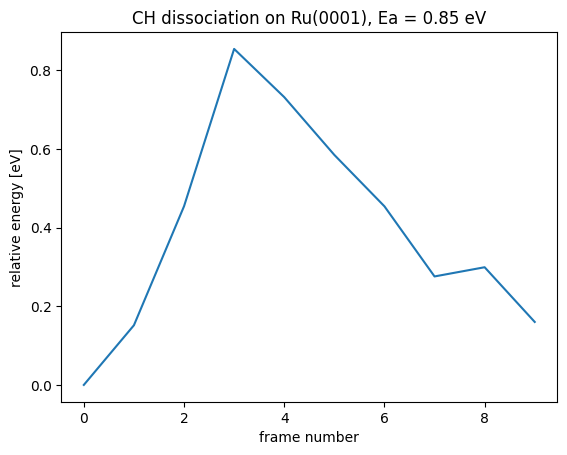

In [15]:
# Plot the reaction coordinate

es = [e - es[0] for e in es]
plt.plot(es)
plt.xlabel("frame number")
plt.ylabel("relative energy [eV]")
plt.title(f"CH dissociation on Ru(0001), Ea = {max(es):1.2f} eV")
plt.savefig("CH_dissoc_on_Ru_0001.png")

To generalize an interactive visualization, use `ase gui` from the command line or the X3D package

In [ ]:
# Make an interative html file of the optimized neb trajectory
x3d = X3D(optimized_neb)
x3d.write("optimized_neb_ch_disoc_on_Ru0001.html")